# The LAC Project 2024/2025

# Import Libraries

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')
plt.style.use('tableau-colorblind10')
color='#702A7D'
grey_color = '#A9A9A9'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

# Define Query for Import

In [3]:
# CPP Data
cpp_query = """
SELECT
  a.person_id, a.YearOfBirth
  ,a.PCArea, a.EthnicOrigin, a.CPP_Category
  ,a.StartDate, a.EndDate
  ,p.birth_datetime AS DateOfBirth
FROM
    yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CPP AS a
LEFT JOIN
    yhcr-prd-bradfor-bia-core.CB_2649.person AS p
ON
    a.person_id = p.person_id
"""

# ------- LAC Data ---------------

lac_query = """
WITH LatestAssessment AS (
    SELECT
        a.person_id,
        a.StartDate,
        ROW_NUMBER() OVER (PARTITION BY a.person_id ORDER BY a.StartDate DESC) as rn,
        f.category
    FROM
        yhcr-prd-bradfor-bia-core.CB_2649.tbl_bmbc_Childrens_Social_Services_Assessments AS a
    LEFT JOIN
        yhcr-prd-bradfor-bia-core.CB_2649.cb_FactorLookup AS f
        ON a.factorid = f.factorid
)
SELECT
  a.person_id, a.YearOfBirth
  ,a.PCArea_Home AS PCArea, a.EthnicOrigin
  ,a.StartDate, a.EndDate
  ,p.birth_datetime AS DateOfBirth
  ,la.category AS Category
FROM
  yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiC AS a

LEFT JOIN
    yhcr-prd-bradfor-bia-core.CB_2649.person AS p
ON
    a.person_id = p.person_id
LEFT JOIN
    LatestAssessment la
    ON a.person_id = la.person_id
    AND la.rn = 1;
"""
# -------- CiNP Data ----------
cinp_query = """
WITH LatestAssessment AS (
    SELECT
        a.person_id,
        a.StartDate,
        ROW_NUMBER() OVER (PARTITION BY a.person_id ORDER BY a.StartDate DESC) as rn,
        f.category
    FROM
        yhcr-prd-bradfor-bia-core.CB_2649.tbl_bmbc_Childrens_Social_Services_Assessments AS a
    LEFT JOIN
        yhcr-prd-bradfor-bia-core.CB_2649.cb_FactorLookup AS f
        ON a.factorid = f.factorid
)
SELECT
  a.person_id, a.YearOfBirth
  ,a.PCArea, a.EthnicOrigin
  ,a.StartDate, a.EndDate
  ,p.birth_datetime AS DateOfBirth
  ,la.category AS Category
FROM
  yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiNP AS a
  
LEFT JOIN
    yhcr-prd-bradfor-bia-core.CB_2649.person AS p
ON
    a.person_id = p.person_id
LEFT JOIN
    LatestAssessment la
    ON a.person_id = la.person_id
    AND la.rn = 1;
"""

# Load Queries into dataframes

In [4]:
cpp = pandas_gbq.read_gbq(cpp_query)
lac = pandas_gbq.read_gbq(lac_query)
cinp = pandas_gbq.read_gbq(cinp_query)

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|


## CPP - Child Protection Plan

In [5]:
# First few rows of cpp
cpp.head()

,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth
0,C9B1DB2054F1D69B674BA78B879110113E7EBB6CF229D4...,2021,,Asian/British Asian - Pakistani,Neglect,2021-01-26,NaT,2021-02-15 00:00:00+00:00
1,CE05511AE9E947ED3248AD446BFCFBBCBB0E07FDC458A9...,2021,,White - British,Emotional Abuse,2021-01-12,NaT,2021-05-15 00:00:00+00:00
2,A53B7CB131455D1FF1868DD79CF73BCD273FC814D512FB...,2021,,White - British,Neglect,2021-05-06,NaT,2021-05-15 00:00:00+00:00
3,A8761FA45B1F1618DDB6D1AC16A4EF230E25BC0BF59273...,2021,,White - British,Emotional Abuse,2020-11-05,NaT,2021-04-15 00:00:00+00:00
4,FC64B02447FD8AA2E9CAC290A5BA7A183F70EBC9225EE3...,2021,,Other Ethnic Group,Emotional Abuse,2020-11-24,NaT,2021-03-15 00:00:00+00:00


In [6]:
# CPP columns overview
cpp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     4112 non-null   object             
 1   YearOfBirth   4112 non-null   Int64              
 2   PCArea        4112 non-null   object             
 3   EthnicOrigin  4112 non-null   object             
 4   CPP_Category  4112 non-null   object             
 5   StartDate     4112 non-null   dbdate             
 6   EndDate       3216 non-null   dbdate             
 7   DateOfBirth   4110 non-null   datetime64[us, UTC]
dtypes: Int64(1), datetime64[us, UTC](1), dbdate(2), object(4)
memory usage: 261.1+ KB


In [7]:
# Total null values per column
cpp.isnull().sum()

person_id         0
YearOfBirth       0
PCArea            0
EthnicOrigin      0
CPP_Category      0
StartDate         0
EndDate         896
DateOfBirth       2
dtype: int64

In [8]:
# Locate entries that have missing DateOfBirth
cpp.loc[cpp.DateOfBirth.isnull()]

,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth
1643,E1ADD1120F8811711A506B9BE016B111BBCEBBC6ACAAE8...,2008,BD3,Gypsy/Roma,Emotional Abuse,2020-01-22,NaT,NaT
2665,5FC5E11E7C47ADFA281F362ED6DD92390BB98C59DCB796...,2003,BD5,Gypsy/Roma,Emotional Abuse,2017-08-03,2018-07-04,NaT


In [9]:
# Fill the missing date of birth as 15th of January. All DoB have day of birth as 15th
cpp.loc[1643, 'DateOfBirth'] = '2008-01-15'
cpp.loc[2665, 'DateOfBirth'] = '2003-01-15'

In [10]:
# Locate entries that have missing DateOfBirth
cpp.loc[cpp.DateOfBirth.isnull()]

,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth


In [11]:
# Convert the dates to datetime format
cpp['StartDate'] = pd.to_datetime(cpp['StartDate'])
cpp['EndDate'] = pd.to_datetime(cpp['EndDate'])
cpp['DateOfBirth'] = pd.to_datetime(cpp['DateOfBirth'])

# Verify
cpp.dtypes

person_id                    object
YearOfBirth                   Int64
PCArea                       object
EthnicOrigin                 object
CPP_Category                 object
StartDate            datetime64[ns]
EndDate              datetime64[ns]
DateOfBirth     datetime64[us, UTC]
dtype: object

In [12]:
# Timeline of the dataset
minimum_start_date = np.min(cpp['StartDate'])
last_start_date = np.max(cpp['StartDate'])

print(f"The CPP Data starts from: {minimum_start_date}")
print(f"The last start date is: {last_start_date}")

The CPP Data starts from: 2017-04-03 00:00:00
The last start date is: 2021-06-09 00:00:00


In [13]:
# Check for duplicates
cpp.duplicated().sum()

1

In [14]:
# Locate the duplicate entry
cpp.loc[cpp.duplicated(keep=False)]

,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth
252,FF716DF11C69D25EF44E3D80ABD4F6A825C39C4A1DE162...,2006,BD10,White - British,Emotional Abuse,2021-06-08,NaT,2006-04-15 00:00:00+00:00
253,FF716DF11C69D25EF44E3D80ABD4F6A825C39C4A1DE162...,2006,BD10,White - British,Emotional Abuse,2021-06-08,NaT,2006-04-15 00:00:00+00:00


In [15]:
# Drop the duplicate entry
cpp.drop_duplicates(inplace=True)

In [16]:
# Number of Persons in the CPP
print(f'Number of Unique IDs: {cpp.person_id.nunique()}')

Number of Unique IDs: 3858


In [17]:
# check for duplicate person_id to see if there are re-entries
print(f"Number of duplicate person_ids: {cpp.duplicated('person_id').sum()} \n")

duplicate_person_ids = cpp.loc[(cpp.duplicated('person_id', keep=False))].sort_values(by='person_id')
duplicate_person_ids

Number of duplicate person_ids: 253 



,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth
2535,008C85F7AFFEBB0EE13C2E9AE8B2B2200F6C82CB6E669D...,2012,BD4,White - British,Emotional Abuse,2018-11-02,2019-01-21,2012-12-15 00:00:00+00:00
2487,008C85F7AFFEBB0EE13C2E9AE8B2B2200F6C82CB6E669D...,2012,BD4,White - British,Sexual Abuse,2017-12-12,2018-04-18,2012-12-15 00:00:00+00:00
2725,01372244D0AF88B0B79598275F53994EE3AC6F6E660F49...,2018,BD5,Mixed - White/Black Caribbean,Emotional Abuse,2018-05-08,2018-07-31,2018-01-15 00:00:00+00:00
2708,01372244D0AF88B0B79598275F53994EE3AC6F6E660F49...,2018,BD5,Mixed - White/Black Caribbean,Emotional Abuse,2020-06-04,2021-05-14,2018-01-15 00:00:00+00:00
2194,022AD16AEA5FE467DFCB98859000673FBCF8744A266FE4...,2014,BD4,White - British,Emotional Abuse,2019-02-14,2019-10-10,2014-05-15 00:00:00+00:00
...,...,...,...,...,...,...,...,...
1169,FCE6CBBDA7F79D00DD3A7F966318B617AFB52FB114ADE1...,2007,BD2,Black/Black British - African,Physical Abuse,2018-11-26,2019-06-13,2007-01-15 00:00:00+00:00
3202,FD9775045A482617E039517008FC46729078E806E008CA...,2017,BD6,White - British,Emotional Abuse,2019-07-01,2019-08-28,2017-01-15 00:00:00+00:00
3041,FD9775045A482617E039517008FC46729078E806E008CA...,2017,BD6,White - British,Neglect,2018-12-18,2019-02-27,2017-01-15 00:00:00+00:00
1768,FF3734FC4D837A4D12ED15F152E413E9FDFBE5A49162D6...,2006,BD3,Asian/British Asian - Other,Emotional Abuse,2017-05-03,2018-05-21,2006-08-15 00:00:00+00:00


In [18]:
# Display top 10 Persons with re-entries
duplicate_person_ids.person_id.value_counts().head(10)

person_id
F83D53AE95DE879DBD5EF8E60166668CE07198C10A721F1CE4F3A81111DDA232    3
C18573ADE1394BFAE179CF2E9D781B4C4DFB1CD5050729B01CD77F749BD2250A    3
FAE156C2E482B67D764084BF693CD413B6F1E4639855FFF5694977EDA595AAE2    3
1731ED06071796047178F013B2FF00E3F9C488574BF7BB7D1545E81458207084    3
A22A659306B82A78378A21AEE2CB4AFBCBA18A96F7410D17BCC49111846DA951    3
AEA57FAB558A42E219DA6FB1981DA25F20145FFC1E950DCC42D62664678ED945    2
B09B1EA9CA9CEBE0B84B15B598EBCB4E41744F01A41B763D49014D364ECF8178    2
B091E51CDA2571F93BB0B62A80A8F8BEDB09999F62EAA7D5286FDC9223D8F8E1    2
B0398D79BAFA5C2CB176DD699BD3B1A93BC7D18B29C4DCAECE492EEA79EC7B2C    2
AF45410622CFBD91E685E493C0F5C9234627D4BC373ADCE19F9713139A69B1F5    2
Name: count, dtype: int64

________
### **Observations:**
* We have 3858 unique persons in the dataset
* We have one duplicate entries 
* 253 persons (6.6%) have re-entered into the protection system. The maximum number of re-entry is 3

**Data Changes:**
* Removed the duplicate entry
* Assigned January to get date of birth of two children missing DoBs
* Converted dates to datetime format

## Data Exploration

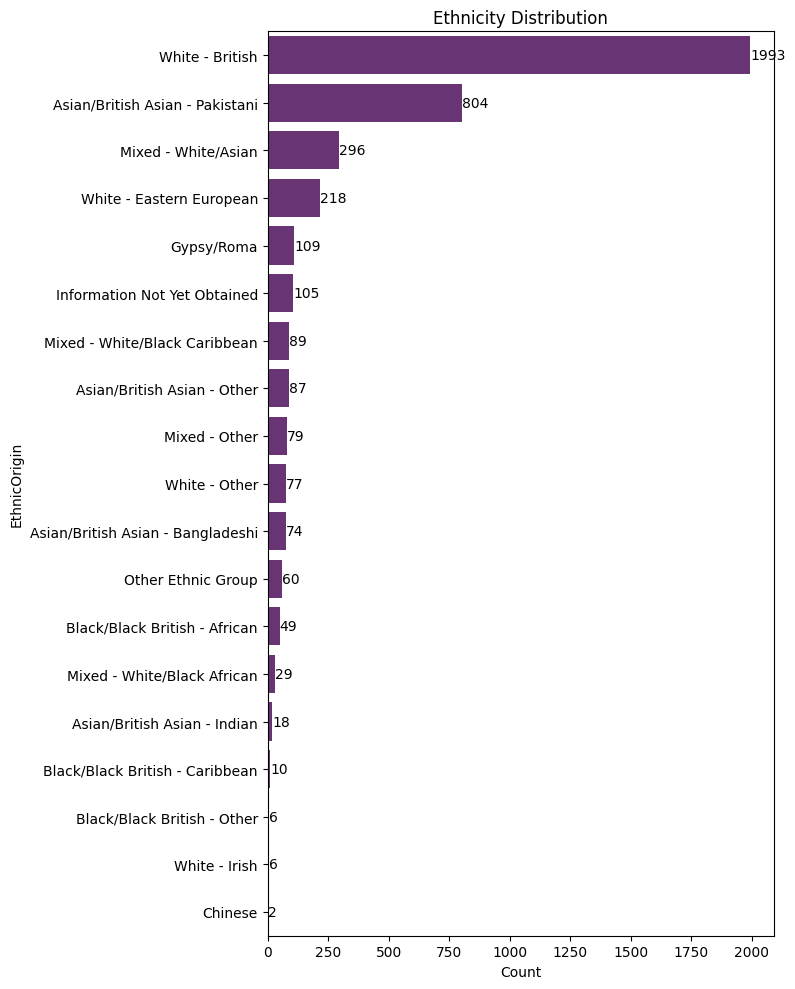

In [19]:
# Ethnicity Distribution
plt.figure(figsize=(8,10))
ax = sns.countplot(data=cpp, 
                   y='EthnicOrigin',
                   order= cpp['EthnicOrigin'].value_counts().sort_values(ascending=False).index,
                   color=color)
ax.set_title('Ethnicity Distribution')
ax.set_xlabel('Count')

# Add counts to the bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

___
* **White-British and Asian/British Pakistani** children accounted for **68%** of the children that entered the CPP from April 2017
* **White-British** children alone accounts for **48.48% - almost half**. This is quite understandable given the fact that the dataset is from England.

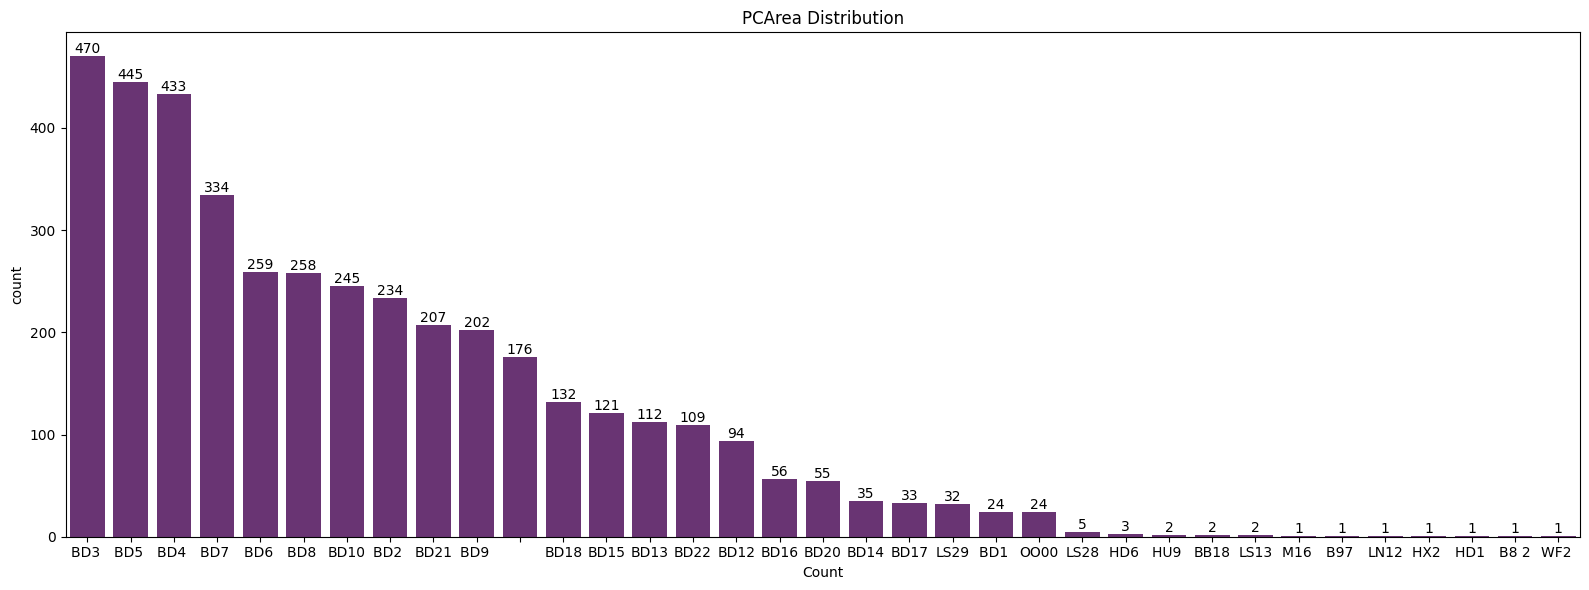

In [20]:
#### PCArea Distribution
plt.figure(figsize=(16,6))
ax = sns.countplot(data=cpp, 
                   x='PCArea',
                   order= cpp['PCArea'].value_counts().sort_values(ascending=False).index,
                   color=color)
ax.set_title('PCArea Distribution')
ax.set_xlabel('Count')

# Add counts to the bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

In [21]:
# Statistics of the Area Distribution
print(f"Average number of children in CPP per area: {cpp.PCArea.value_counts().mean()}")
print(f"Median number of children in CPP per area: {cpp.PCArea.value_counts().median()}")
print(f"STD of children in CPP per area: {round(cpp.PCArea.value_counts().std(),2)}")

Average number of children in CPP per area: 117.45714285714286
Median number of children in CPP per area: 55.0
STD of children in CPP per area: 140.82


______

* The high STD from the mean suggests there is significant variablity across the different PCAreas. **470 in BD3, 24 in BD1** is an example of this variance.

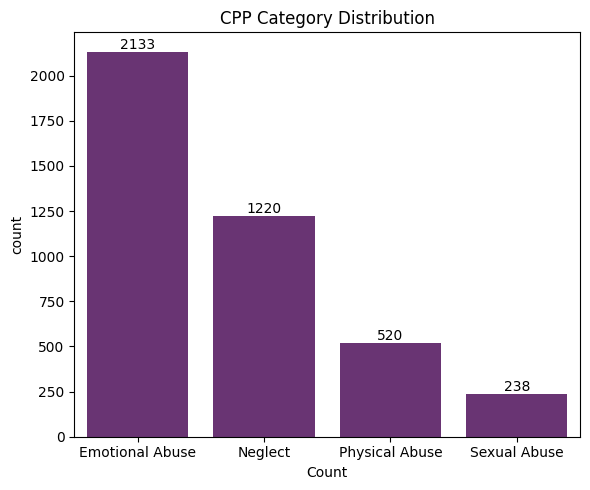

In [22]:
"""
What's the most common reason for intervention?

"""

# CPP Category Distribution
plt.figure(figsize=(6,5))
ax = sns.countplot(data=cpp, 
                   x='CPP_Category',
                   order= cpp['CPP_Category'].value_counts().sort_values(ascending=False).index,
                   color=color)
ax.set_title('CPP Category Distribution')
ax.set_xlabel('Count')

# Add counts to the bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

_______

**Observation:**
* **Emotional Abuse** accounts for just more than half **(51.79%)** of the reasons for intervention.

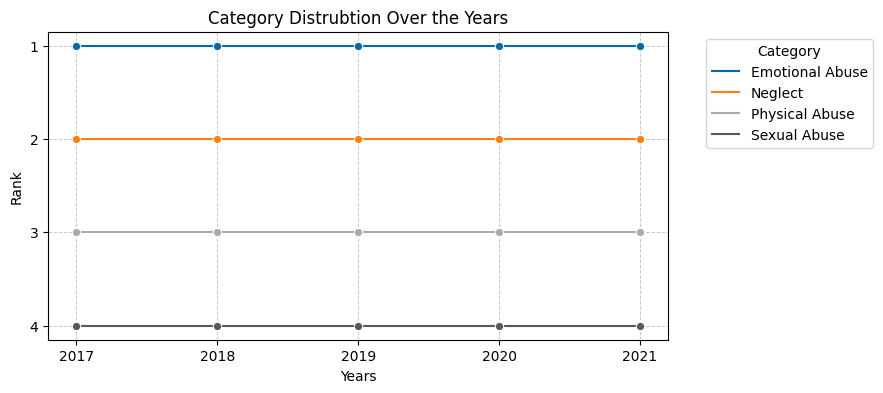

In [23]:
# Category Distribution over the Years
# Get Year value
cpp['Year'] = cpp['StartDate'].dt.year

# Group by year and category and count entries
category_counts = cpp.groupby(['Year', 'CPP_Category']).size().reset_index(name='count')

#Rank categories within each year
category_counts['rank'] = category_counts.groupby('Year')['count'].rank(method='first', ascending=False)

# PLOT
plt.figure(figsize=(8,4))

# Create the bump chart
sns.lineplot(data=category_counts, x='Year', y='rank', hue='CPP_Category', marker='o')

# Set x-axis to integer value only
plt.xticks(category_counts['Year'].unique())

# Set y-axis to integer value only
plt.yticks(category_counts['rank'].unique())

# Invert y-axis to have highest rank at the top
plt.gca().invert_yaxis()

# Add Labels and titles
plt.title('Category Distrubtion Over the Years')
plt.xlabel('Years')
plt.ylabel('Rank')
plt.grid(True, which='both', linestyle='--', linewidth=.7, alpha=.7)
plt.legend(title='Category', bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

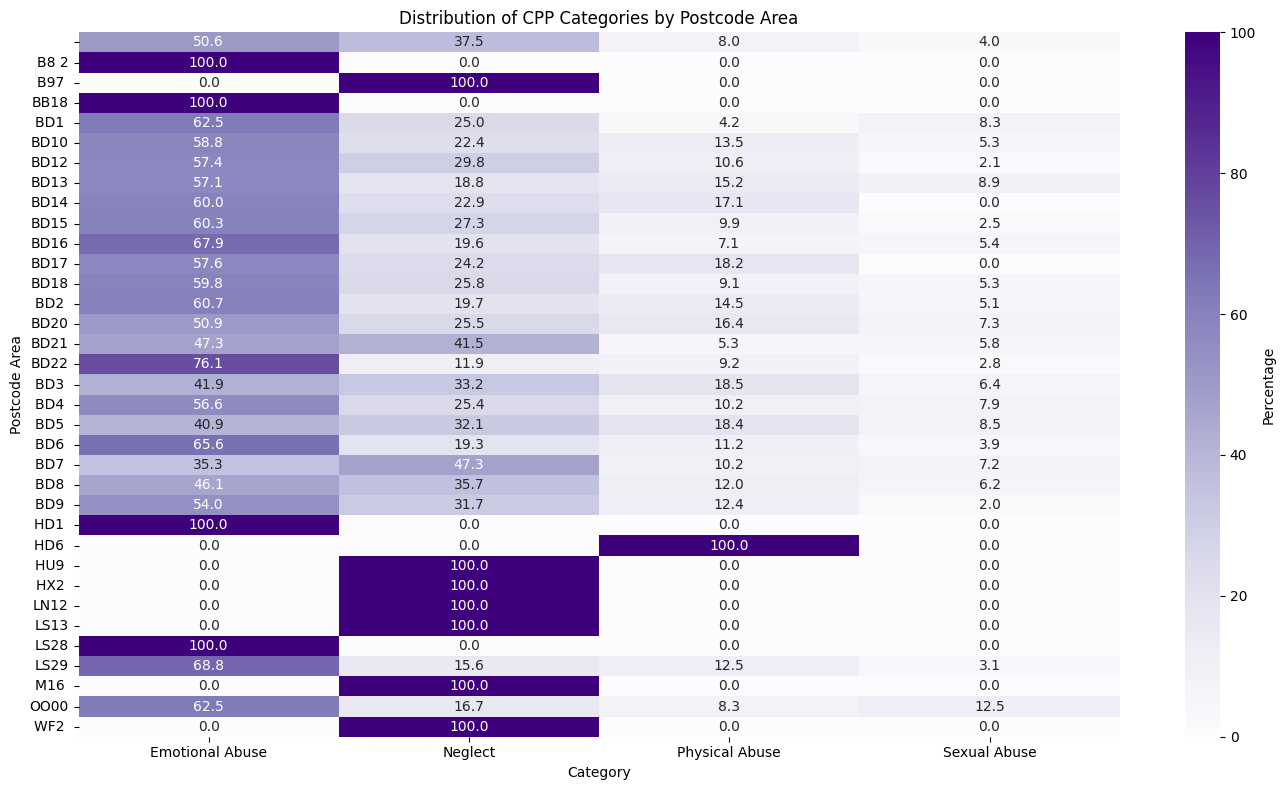

In [24]:
"""
Is there pattern(s) in intervention reasons across areas?

"""


# Create a pivot table to count occurrences of each categories in each postcode area
pivot_table = cpp.pivot_table(index='PCArea', columns='CPP_Category', aggfunc='size', fill_value=0)

# Convert counts to percentages
percentage_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Plot a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(percentage_table, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Percentage'})
plt.title('Distribution of CPP Categories by Postcode Area')
plt.xlabel('Category')
plt.ylabel('Postcode Area')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

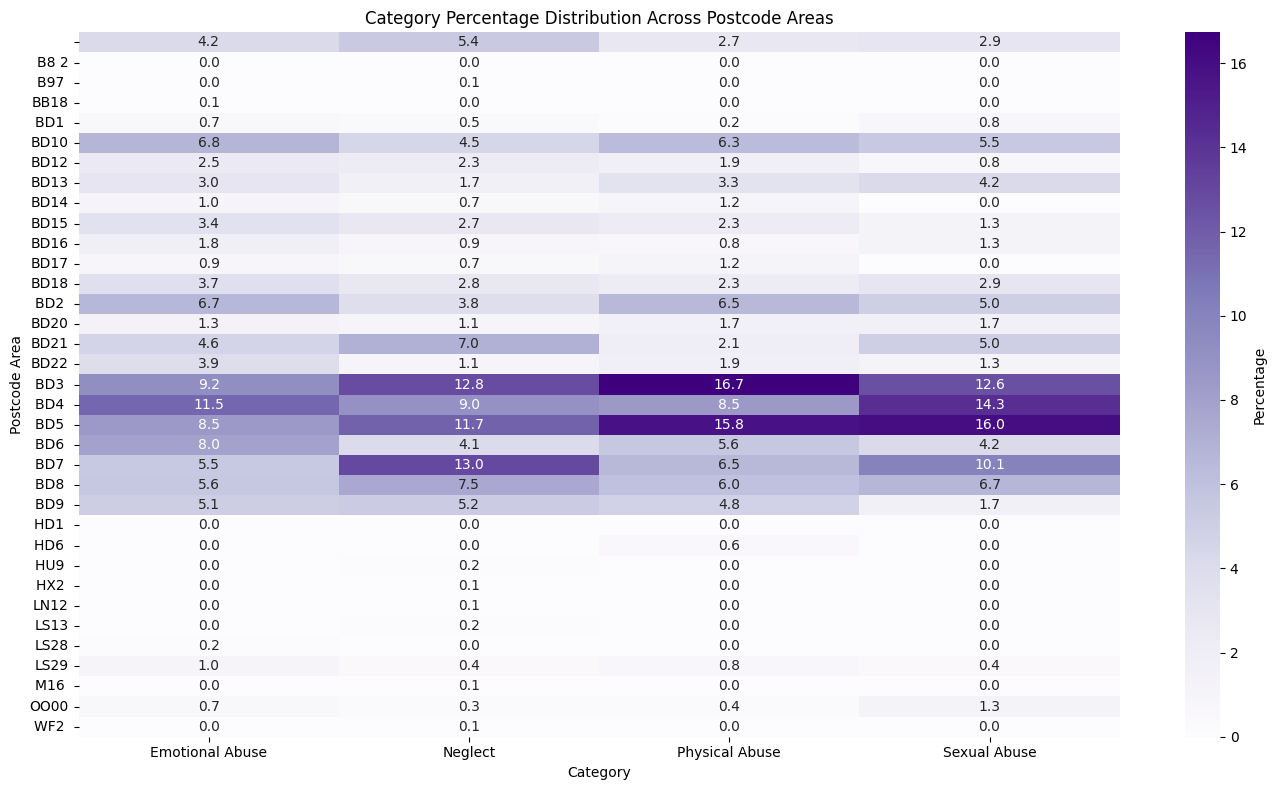

In [25]:
# Create a pivot table to count occurrences of each reason in each postcode area
pivot_table = cpp.pivot_table(index='PCArea', columns='CPP_Category', aggfunc='size', fill_value=0)

# Convert counts to percentages by categories
percentage_table_by_category = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100

# Plot a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(percentage_table_by_category, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Percentage'})
plt.title('Category Percentage Distribution Across Postcode Areas')
plt.xlabel('Category')
plt.ylabel('Postcode Area')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

______
The above plots helps us see how the CPP categories are distributed at each postcode and across all postcodes areas<br>


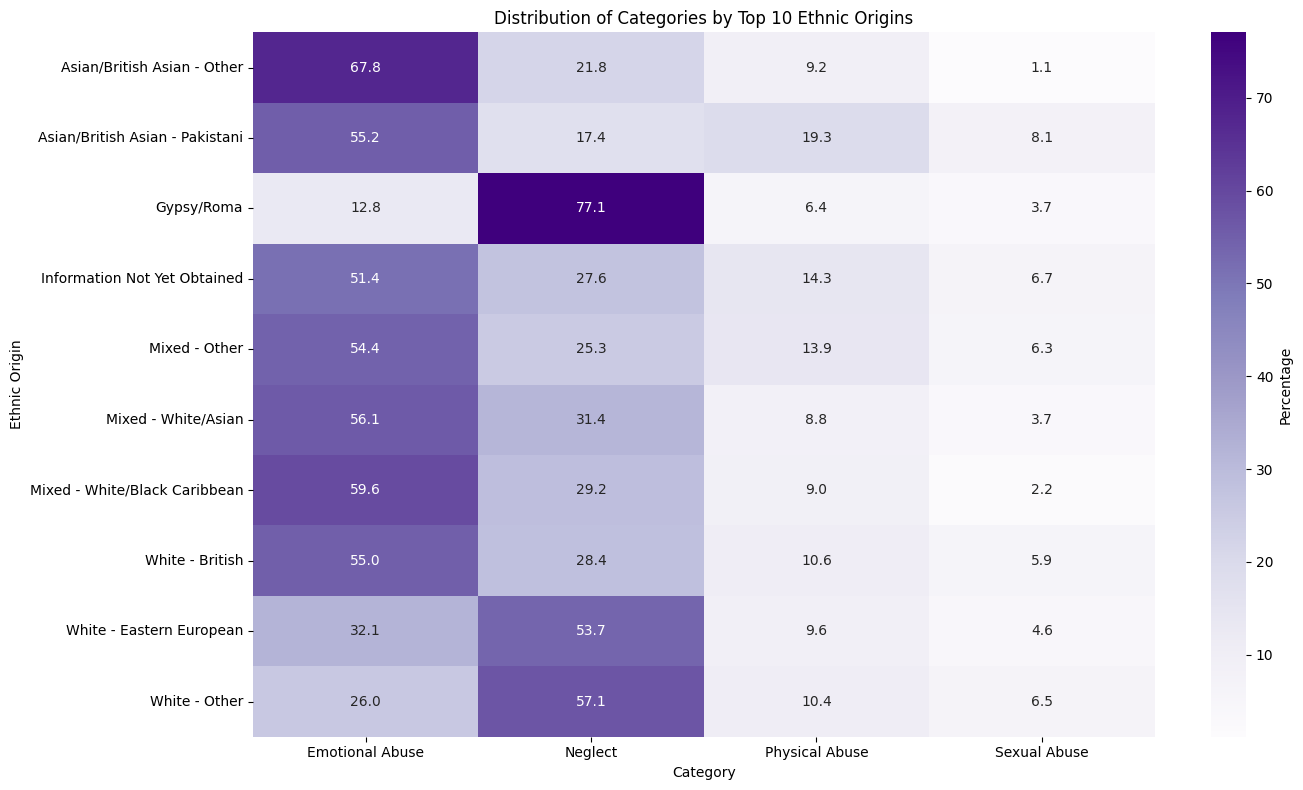

In [26]:
"""
What's the distribution of the categories by the Ethnicity and across Ethnicities?

"""
# Identify the top 10 most frequent ethnic origins
top_ethnic_origins = cpp['EthnicOrigin'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 ethnic origins
filtered_cpp = cpp[cpp['EthnicOrigin'].isin(top_ethnic_origins)]

# Create a pivot table to count occurrences of each categories  in each Ethnic Origin
pivot_table_ethnicity = filtered_cpp.pivot_table(index='EthnicOrigin', columns='CPP_Category', aggfunc='size', fill_value=0)

# Convert counts to percentages by categories
percentage_table_by_ethnic_origin = pivot_table_ethnicity.div(pivot_table_ethnicity.sum(axis=1), axis=0) * 100

# Plot a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(percentage_table_by_ethnic_origin, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Percentage'})
plt.title('Distribution of Categories by Top 10 Ethnic Origins')
plt.ylabel('Ethnic Origin')
plt.xlabel('Category')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

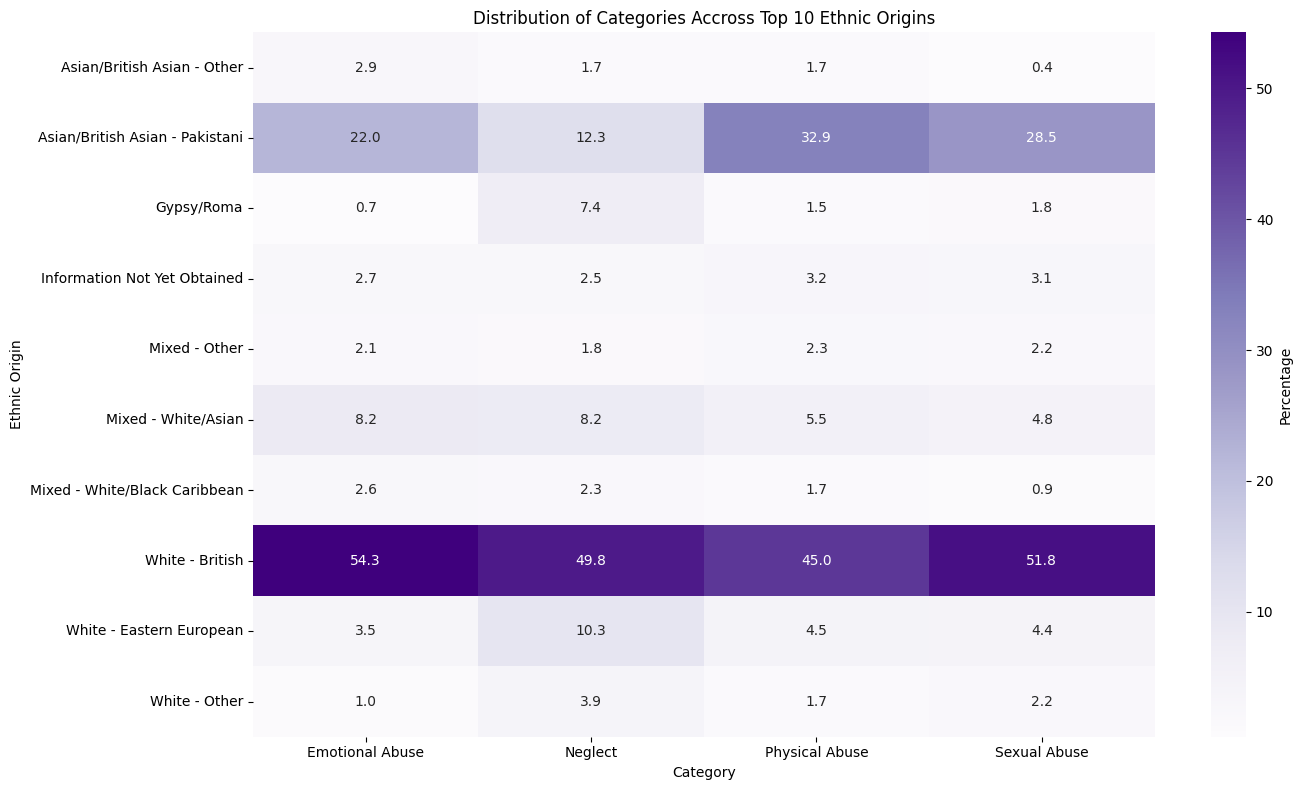

In [27]:
# Identify the top 10 most frequent ethnic origins
top_ethnic_origins = cpp['EthnicOrigin'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 ethnic origins
filtered_cpp = cpp[cpp['EthnicOrigin'].isin(top_ethnic_origins)]

# Create a pivot table to count occurrences of each categories  in each Ethnic Origin
pivot_table_ethnicity = filtered_cpp.pivot_table(index='EthnicOrigin', columns='CPP_Category', aggfunc='size', fill_value=0)

# Convert counts to percentages by categories
percentage_table_by_ethnic_origin = pivot_table_ethnicity.div(pivot_table_ethnicity.sum(axis=0), axis=1) * 100

# Plot a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(percentage_table_by_ethnic_origin, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Percentage'})
plt.title('Distribution of Categories Accross Top 10 Ethnic Origins')
plt.ylabel('Ethnic Origin')
plt.xlabel('Category')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

It's not surprising that the White-British and Asian/British-Pakistani are dominating the categories across all ethnicites giving that they account for 68% of all entries.<br>
Hence, it's better to look at this at the POV of each Ethnic group.
_______
### What is the distribution of the Children in terms of Age at their time of entry into the intervention?

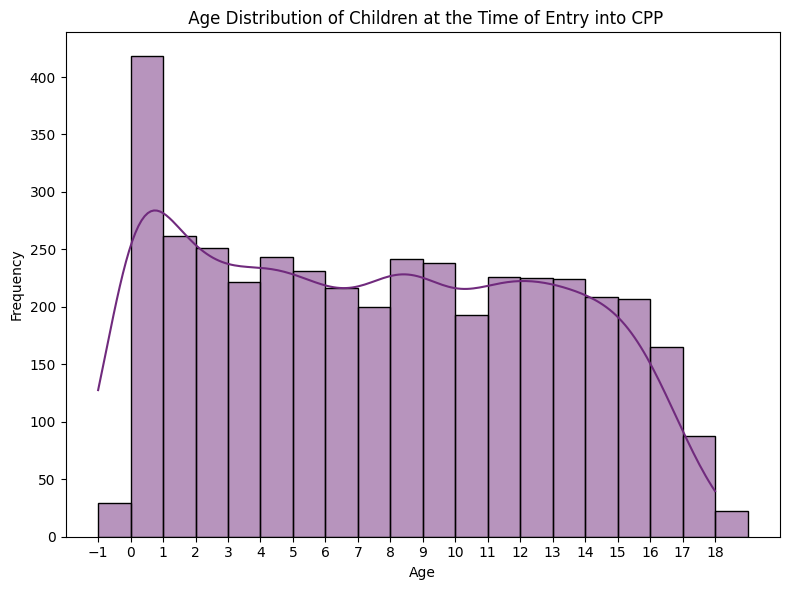

In [28]:
"""
What is the distribution of the Children in terms of Age at their time of entry into the intervention?

"""

# Calculate the age of each children by substracting their birth year from the year they entered the CPP
cpp['AgeAtEntry'] = (cpp['StartDate'].dt.year - cpp['DateOfBirth'].dt.year).astype(int)

max_age = cpp['AgeAtEntry'].max()

# Plot the distribution of the Ages
plt.figure(figsize=(8,6))
sns.histplot(data=cpp, x='AgeAtEntry', color=color, kde=True, bins=range(-1, cpp['AgeAtEntry'].max() + 2));
plt.title(' Age Distribution of Children at the Time of Entry into CPP')
plt.ylabel('Frequency')
plt.xlabel('Age')

# Set x-ticks to be integers
plt.xticks(np.arange(-1, max_age+1, step=1))
plt.tight_layout()
plt.show()

In [29]:
# Locate entries where AgeAtEntry < 0 i.e They entered CPP before birth
special_cases = cpp.loc[cpp.AgeAtEntry < 0]
print(f'Number of cases with negative age at entry: {len(special_cases)}')
special_cases.head()

Number of cases with negative age at entry: 29


,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth,Year,AgeAtEntry
3,A8761FA45B1F1618DDB6D1AC16A4EF230E25BC0BF59273...,2021,,White - British,Emotional Abuse,2020-11-05,NaT,2021-04-15 00:00:00+00:00,2020,-1
4,FC64B02447FD8AA2E9CAC290A5BA7A183F70EBC9225EE3...,2021,,Other Ethnic Group,Emotional Abuse,2020-11-24,NaT,2021-03-15 00:00:00+00:00,2020,-1
33,B108A841D100EBE026894C6D5E9A601883A739EFD59C80...,2019,,White - British,Emotional Abuse,2018-12-05,2019-11-05,2019-04-15 00:00:00+00:00,2018,-1
38,556692F091F2123B903CC5A66CBE9A7BCBA0BAA80AC1DB...,2019,,Asian/British Asian - Pakistani,Emotional Abuse,2018-12-07,2019-02-25,2019-01-15 00:00:00+00:00,2018,-1
49,0E85C037591146EF8AB54A67B646A5FABBBBB5A565D2CC...,2019,,White - British,Emotional Abuse,2018-12-18,2019-03-07,2019-03-15 00:00:00+00:00,2018,-1


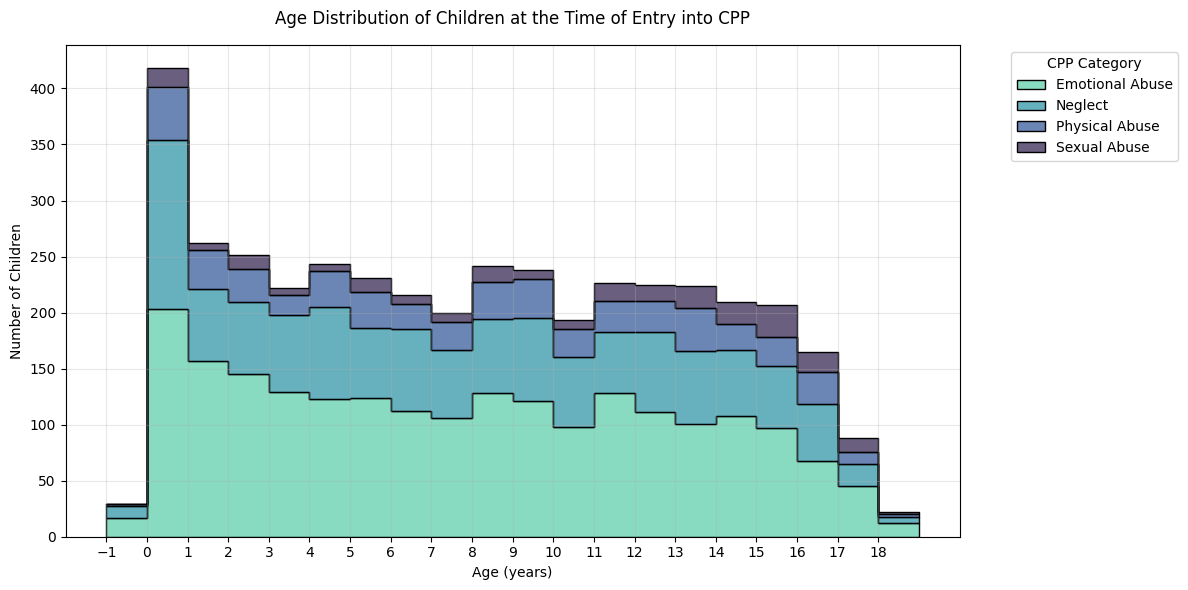

In [30]:
# Create the figure  
plt.figure(figsize=(12, 6))  

# Define the order of categories based on their counts (from highest to lowest)  
category_order = ['Emotional Abuse', 'Neglect', 'Physical Abuse', 'Sexual Abuse']  

# Create the histogram plot with ordered categories  
hist = sns.histplot(  
    data=cpp,     
    x='AgeAtEntry',     
    hue='CPP_Category',     
    multiple="stack",  
    element='step',     
    hue_order=category_order[::-1],  # Reverse the order for proper stacking  
    palette='mako',
    bins=np.arange(-1, 20, 1),  
    stat='count'  
)  

# Set the title and labels  
plt.title('Age Distribution of Children at the Time of Entry into CPP', fontsize=12, pad=15)  
plt.xlabel('Age (years)', fontsize=10)  
plt.ylabel('Number of Children', fontsize=10)  

# Set x-ticks  
plt.xticks(range(-1, 19, 1))  

# Customize the legend with the correct order  
plt.legend(title='CPP Category',  
          labels=category_order,  # Keep original order in legend  
          bbox_to_anchor=(1.05, 1),  
          loc='upper left')  

# Add grid for better readability  
plt.grid(True, alpha=0.3)  

# Adjust layout
plt.tight_layout()  
plt.show()

* Generally, there seems to be a slight downard trend in CPP entries from young age to older age. Most CPP entries occured at ages 0 and 1.
* There are adults in the dataset i.e 18 year olds
* Even less than 1 year olds experience sexual abuse 

# Monthly Entry and Exit Trends in CPP

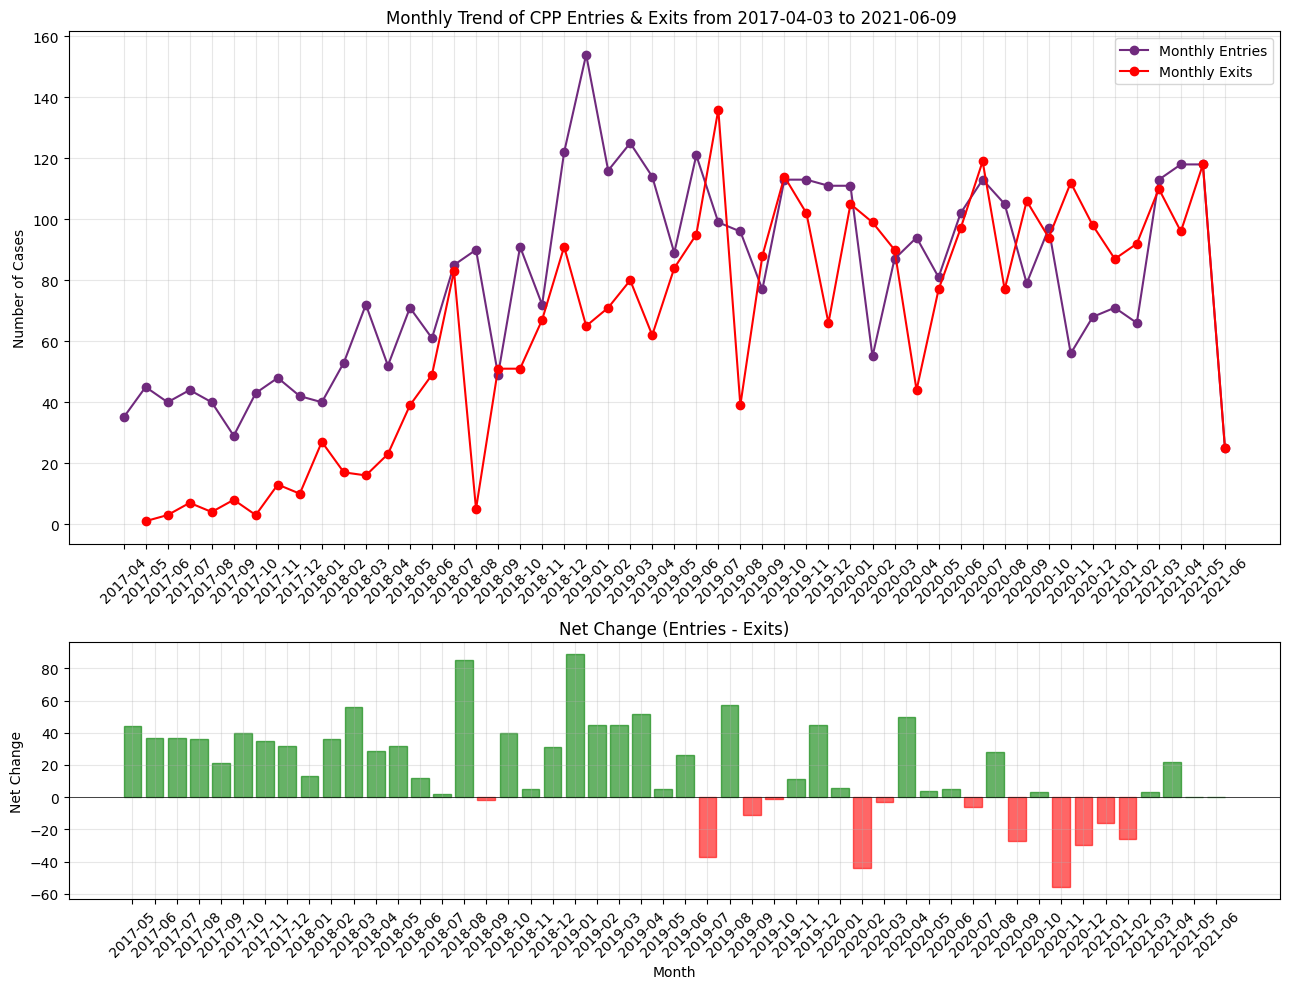


Summary of Net Changes:
Average monthly net change: 17.2
Maximum increase: 89
Maximum decrease: -56
Months with net increase: 36
Months with net decrease: 12


In [31]:
# ENTRIES

# Count entry cases per month
monthly_entries = cpp['StartDate'].dt.to_period('M').value_counts().sort_index()

# Convert PeriodIndex to string for plotting
monthly_entries.index = monthly_entries.index.astype(str)

# EXITS

# Count exit cases per month
monthly_exits = cpp['EndDate'].dt.to_period('M').value_counts().sort_index()
monthly_exits.index = monthly_exits.index.astype(str)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10), height_ratios=[2, 1])

# Top plot: Entries and Exits
ax1.plot(monthly_entries.index, monthly_entries.values, marker='o', color=color, label='Monthly Entries')
ax1.plot(monthly_exits.index, monthly_exits.values, marker='o', color='red', label='Monthly Exits')
ax1.set_title(f'Monthly Trend of CPP Entries & Exits from {cpp.StartDate.min().date()} to {cpp.StartDate.max().date()} ')
ax1.set_xlabel('')
ax1.set_ylabel('Number of Cases')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Bottom plot: Net Change
monthly_entries_aligned = monthly_entries.reindex(monthly_exits.index) # Ensures both series have same index (months).
difference = monthly_entries_aligned - monthly_exits

# Create bar plot for difference
bars = ax2.bar(difference.index, difference.values, color='green', alpha=0.6)

# Add horizontal line at y=0
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Color bars based on positive/negative values
for bar, value in zip(bars, difference.values):
    if value < 0:
        bar.set_color('red')
    else:
        bar.set_color('green')

ax2.set_title('Net Change (Entries - Exits)')
ax2.set_xlabel('Month')
ax2.set_ylabel('Net Change')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.savefig('../figs/EntriesVsExits.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print summary statistics
print("\nSummary of Net Changes:")
print(f"Average monthly net change: {difference.mean():.1f}")
print(f"Maximum increase: {difference.max():.0f}")
print(f"Maximum decrease: {difference.min():.0f}")
print(f"Months with net increase: {(difference > 0).sum()}")
print(f"Months with net decrease: {(difference < 0).sum()}")

______
**Observations:**
* The large decline from May 2021 to June 2021 is due to the latest start date which is 9th of June. Resulting in only 9 days of data compared to at least 28 days for other months.
* Generally there's an upward trend in children entering into the CPP
* Number of months with net increase is 3x the number of months with net decrease.

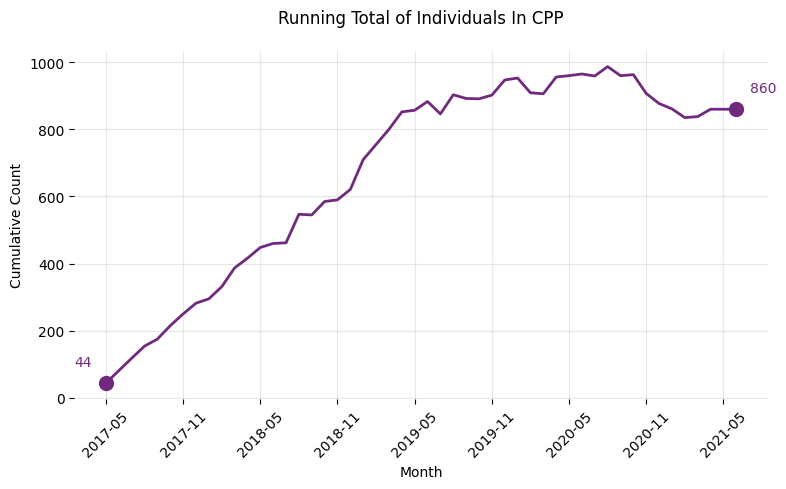

In [32]:
# Align on the same monthly index; fill_value=0 ensures missing months get zero counts
monthly_entries_aligned = monthly_entries.reindex(monthly_exits.index, fill_value=0)

# Calculate monthly net change and the cumulative sum
difference = monthly_entries_aligned - monthly_exits
cumulative_in_intervention = difference.cumsum()  # Running total

cumulative_in_intervention.index = cumulative_in_intervention.index.astype(str)

# Plot the running total
plt.figure(figsize=(8, 5))

# Plot line without markers
plt.plot(cumulative_in_intervention.index, cumulative_in_intervention.values, 
         color=color, linewidth=2)


# Add markers only at start and end points
start_date = cumulative_in_intervention.index[0]
end_date = cumulative_in_intervention.index[-1]
start_value = cumulative_in_intervention.values[0]
end_value = cumulative_in_intervention.values[-1]

# Plot markers
plt.scatter([start_date, end_date], [start_value, end_value], 
            color=color, s=100, zorder=5)

# Annotate start and end values
plt.annotate(f'{int(start_value)}', 
            xy=(start_date, start_value),
            xytext=(-10, 10),  # Offset the text slightly
            textcoords='offset points',
            ha='right',
            va='bottom',
            color=color)

plt.annotate(f'{int(end_value)}', 
            xy=(end_date, end_value),
            xytext=(10, 10),  # Offset the text slightly
            textcoords='offset points',
            ha='left',
            va='bottom',
            color=color)

# Customize the plot
plt.title('Running Total of Individuals In CPP', pad=20)
plt.xlabel('Month')
plt.ylabel('Cumulative Count')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Show every 6th month label
all_xticks = plt.gca().get_xticks()
plt.gca().set_xticks(all_xticks[::6])
plt.xticks(rotation=45)
    
# Remove chart borders
sns.despine(left=True, right=True, top=True, bottom=True)

# Save and show the plot
plt.tight_layout()
#plt.savefig('../figs/cpp_cummsum_in_intervention.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

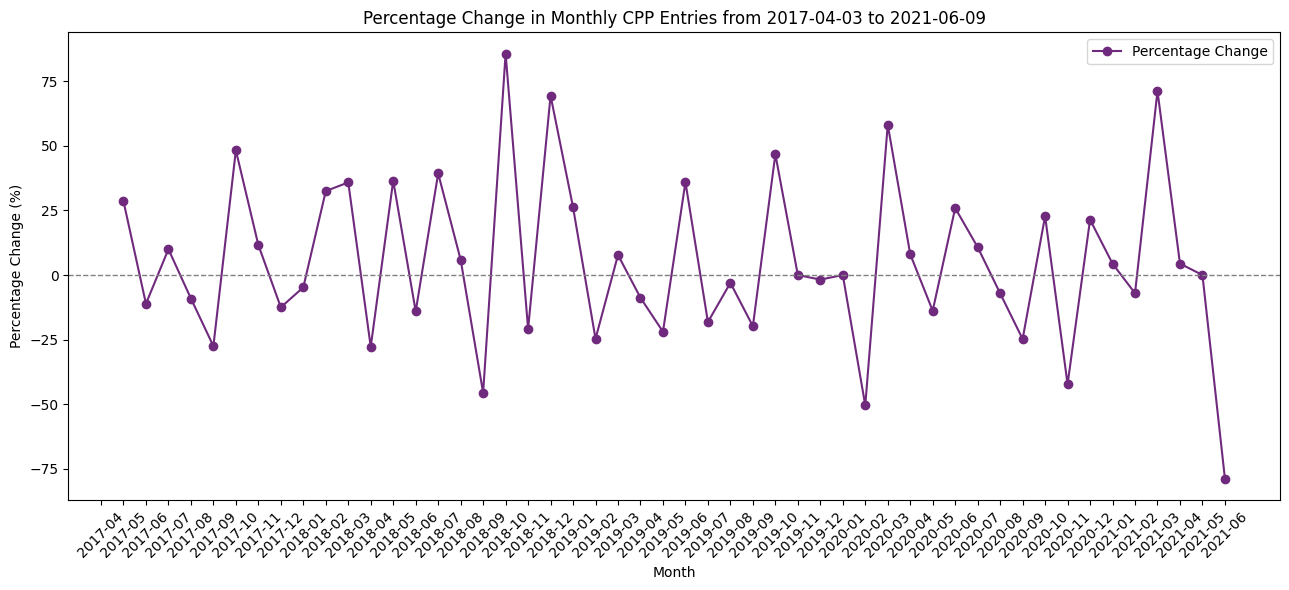

In [33]:
# Percentage change plot
# Calculate the percentage change  
percentage_change = monthly_entries.pct_change() * 100  # Convert to percentage  
  
# Plot the percentage change  
plt.figure(figsize=(13, 6))  
plt.plot(percentage_change.index, percentage_change.values, marker='o', color=color, label='Percentage Change')  
  
# Add a horizontal line at 0% for reference  
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  
  
# Add labels and title  
plt.title(f'Percentage Change in Monthly CPP Entries from {cpp.StartDate.min().date()} to {cpp.StartDate.max().date()}')  
plt.xlabel('Month')  
plt.ylabel('Percentage Change (%)')  
plt.legend()  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

# Number of days in intervention

In [34]:
# Subtract start date from end date to get number of days
cpp['num_of_days_in_intervention'] = (cpp['EndDate'] - cpp['StartDate']).dt.days

#Convert to integer wile preserving NA values using Int64
cpp['num_of_days_in_intervention'] = cpp['num_of_days_in_intervention'].astype('Int64')

In [35]:
# Statistics of CPP Intervention Duration
print("\nBasic Statistics of Intervention Duration:")
print(cpp['num_of_days_in_intervention'].describe().round(2))

print("\nSummary of missing values:")
print(f"Percentage missing: {(cpp['num_of_days_in_intervention'].isna().sum()/len(cpp))*100:.2f}%")


Basic Statistics of Intervention Duration:
count    3216.0
mean     260.86
std      165.91
min         1.0
25%       126.0
50%       237.0
75%       359.0
max      1091.0
Name: num_of_days_in_intervention, dtype: Float64

Summary of missing values:
Percentage missing: 21.77%


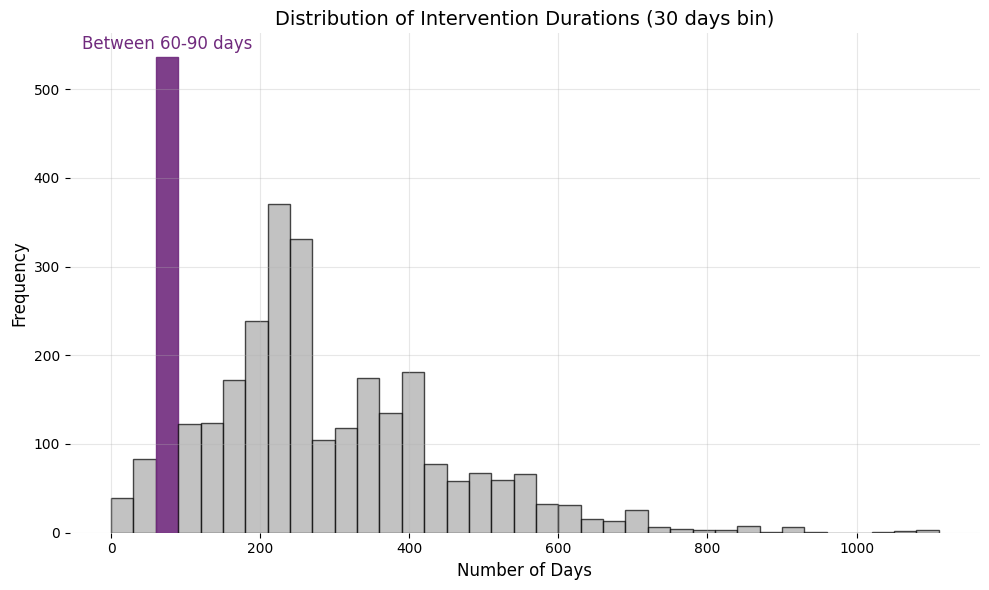

In [36]:
# Distribution of Intervention Durations

# Define the color for the non-highlighted bins
grey_color = '#A9A9A9'  

# Calculate bin edges from 0 to max value with steps of 30 days
bin_edges = np.arange(0, max(cpp['num_of_days_in_intervention'].dropna()) + 30, 30)

# Create histogram with calculated number of bins
plt.figure(figsize=(10, 6))

# Plot the histogram
n, bins, patches = plt.hist(cpp['num_of_days_in_intervention'].dropna(), 
                            bins=bin_edges,
                            color=grey_color,  # Default color for all bars
                            edgecolor='black',
                            alpha=0.7)

# Highlight the 90-day bin
for i, (patch, bin_start) in enumerate(zip(patches, bins)):
    if bin_start == 60:  # Check if the bin starts at 60 days
        patch.set_facecolor(color)  # Set the color for the 60-90 days bin
        patch.set_edgecolor(color)
        patch.set_alpha(0.9)  # Set transparency
        # Annotate the 60-90 day bin
        plt.text(bin_start + 15, n[i] + 5, 'Between 60-90 days', 
                 ha='center', va='bottom', fontsize=12, color=color, weight='normal')

# Customize the plot
plt.title('Distribution of Intervention Durations (30 days bin)', fontsize=14)
plt.xlabel('Number of Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Remove chart borders (spines)
sns.despine(left=True, right=True, top=True, bottom=True)

# Save and show the plot
plt.tight_layout()
# plt.savefig('num_of_days.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [37]:
cpp.columns

Index(['person_id', 'YearOfBirth', 'PCArea', 'EthnicOrigin', 'CPP_Category',
       'StartDate', 'EndDate', 'DateOfBirth', 'Year', 'AgeAtEntry',
       'num_of_days_in_intervention'],
      dtype='object')

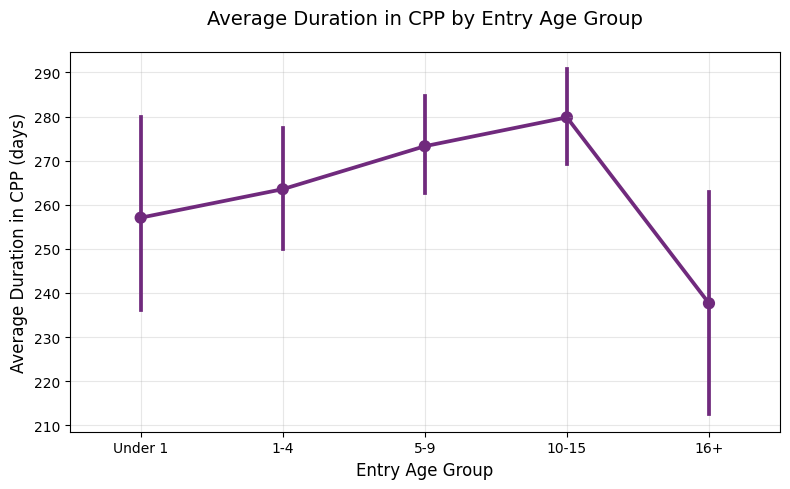

In [38]:
# Group Entry Ages
bins = [0, 1, 4, 9, 15, 16]
labels = ['Under 1', '1-4', '5-9', '10-15', '16+']

# Create new age group column
cpp['entry_agegroup'] = pd.cut(cpp['AgeAtEntry'], bins=bins, labels=labels, right=True)

# Plot distribution of entry age group by  average duration
plt.figure(figsize=(8, 5))
sns.pointplot(x='entry_agegroup', y='num_of_days_in_intervention', data=cpp,
              color=color)
plt.title('Average Duration in CPP by Entry Age Group', fontsize=14, pad=20)
plt.xlabel('Entry Age Group', fontsize=12)
plt.ylabel('Average Duration in CPP (days)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

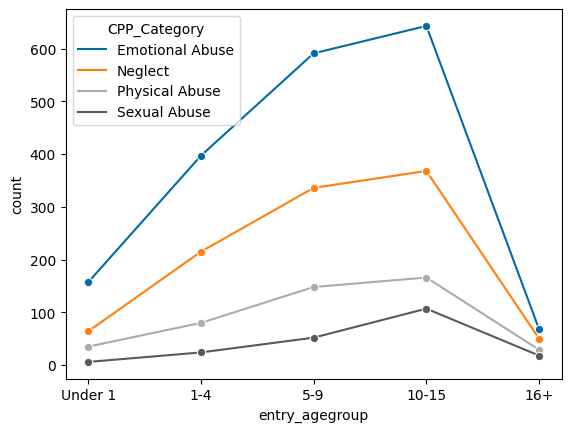

In [39]:
# Create a count DataFrame
count_df = cpp.groupby(['entry_agegroup', 'CPP_Category']).size().reset_index(name='count')

# Create the line plot
sns.lineplot(data=count_df, x='entry_agegroup', y='count', hue='CPP_Category', marker='o')

# Show the plot
plt.show()

# Creating Functions to Reproduce Analysis for LAC and CiNP

In [40]:
def fill_missing_dob(dataframe, year_column, dob_column):  
    """  
    Fills missing date of births in the specified column using the year of birth from another column.  
    The missing dates are filled as January 15th of the corresponding year.  

    Parameters:  
    - dataframe: pd.DataFrame, the dataframe containing the data  
    - year_column: str, the name of the column containing the year of birth  
    - dob_column: str, the name of the column where missing dates of birth will be filled  

    Returns:  
    - pd.DataFrame: The dataframe with missing dates of birth filled  
    """  
    # Iterate through rows where the DateOfBirth column is missing  
    for index, row in dataframe[dataframe[dob_column].isnull()].iterrows():  
        # Use the YearOfBirth column to construct the new date  
        year = row[year_column]  
        if pd.notnull(year):  # Ensure the year is not missing  
            dataframe.loc[index, dob_column] = f"{int(year)}-01-15"  

    return dataframe

In [41]:
def drop_duplicates(dataframe):
    """
    Drops duplicate rows from the dataframe.

    Parameters:
    - dataframe: pd.DataFrame, the dataframe containing the data

    Returns:
    - pd.DataFrame: The dataframe with duplicates removed
    """
    dataframe.drop_duplicates(inplace=True)

In [42]:
def convert_dates_datatype(dataframe, date_columns):
    """
    Converts specified columns to datetime datatype.

    Parameters:
    - dataframe: pd.DataFrame, the dataframe containing the data
    - date_columns: list, the names of the columns to convert to datetime

    Returns:
    - pd.DataFrame: The dataframe with converted datetime columns
    """
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)
    return dataframe

In [43]:
def analyse_person_ids(dataframe, id_column):
    """
    Analyzes the number of unique IDs and checks for duplicate entries in the specified column.

    Parameters:
    - dataframe: pd.DataFrame, the dataframe containing the data
    - id_column: str, the name of the column containing person IDs

    Returns:
    - pd.DataFrame: A dataframe containing duplicate person IDs and their details
    """
    unique_ids = dataframe[id_column].nunique()
    print(f"Number of Unique IDs: {unique_ids}")

    duplicate_count = dataframe.duplicated(id_column).sum()
    print(f"Number of people that re-entered: {duplicate_count} \n")

    duplicate_entries = dataframe.loc[dataframe.duplicated(id_column, keep=False)].sort_values(by=id_column)
    print("\n Top 10 Persons with re-entries:")
    print(duplicate_entries[id_column].value_counts().head(10))

    return duplicate_entries.head()

In [44]:
def add_calculated_columns(dataframe, dob_col='DateOfBirth', start_date_col='StartDate', end_date_col='EndDate'):
    """
    Adds calculated columns to dataframe for age and duration analysis.
    Handles UTC timezone in DateOfBirth column.

    Parameters:
    - dataframe: DataFrame containing the data
    - dob_col: Column name for date of birth (default: 'DateOfBirth')
    - start_date_col: Column name for start date (default: 'StartDate')
    - end_date_col: Column name for end date (default: 'EndDate')

    Returns:
    - DataFrame with added columns:
        - AgeAtEntry: Age when entering intervention (years)
        - num_of_days_in_intervention: Duration of intervention (days)
        - entry_agegroup: Categorized age groups
    """
    # Create copy of dataframe to avoid modifying original
    df = dataframe.copy()

    # Convert DateOfBirth from UTC to timezone-naive
    df[dob_col] = df[dob_col].dt.tz_localize(None)

    # Calculate age at entry (in years)
    df['AgeAtEntry'] = ((df[start_date_col] - df[dob_col]).dt.days / 365.25).astype(int)

    # Calculate duration in intervention
    df['num_of_days_in_intervention'] = (df[end_date_col] - df[start_date_col]).dt.days
    df['num_of_days_in_intervention'] = df['num_of_days_in_intervention'].astype('Int64')

    # Create age groups
    bins = [0, 1, 4, 9, 15, 16]
    labels = ['Under 1', '1-4', '5-9', '10-15', '16+']
    df['entry_agegroup'] = pd.cut(df['AgeAtEntry'], 
                                 bins=bins, 
                                 labels=labels, 
                                 right=True)

    return df

In [45]:
def plot_distributions(dataframe, color=color):
    """
    Creates distribution plots for Ethnicity and PCArea.

    Parameters:
    - dataframe: pd.DataFrame, the dataframe containing the data
    - color: str, optional, color for the plots (default is "blue")
    """
    # Ethnicity Distribution
    plt.figure(figsize=(8, 10))
    ax = sns.countplot(
        data=dataframe,
        y="EthnicOrigin",
        order=dataframe["EthnicOrigin"].value_counts().sort_values(ascending=False).index,
        color=color,
    )
    ax.set_title("Ethnicity Distribution")
    ax.set_xlabel("Count")
    
    # Remove the x-axis labels
    plt.gca().set_xticklabels([])
    
    for container in ax.containers:
        ax.bar_label(container, fmt="%d")
    plt.tight_layout()
    plt.show()

    # PCArea Distribution
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(
        data=dataframe,
        x="PCArea",
        order=dataframe["PCArea"].value_counts().sort_values(ascending=False).index,
        color=color,
    )
    ax.set_title("PCArea Distribution")
    ax.set_xlabel("Postcode Area")
    
    # Remove the x-axis labels
    plt.gca().set_yticklabels([])
    
    ax.tick_params(axis="x", rotation=45)
    for container in ax.containers:
        ax.bar_label(container, fmt="%d")
    plt.tight_layout()
    plt.show()

In [46]:
def plot_age_distribution(dataframe, intervention_name, startdate, birth_date_column, color=color, grey_color=grey_color):
    """
    Plots age distribution for a given DataFrame with two subplots:
    1. Continuous age distribution
    2. Age group distribution with highlighted highest frequency bar

    Parameters:
    - dataframe: pd.DataFrame, the input DataFrame
    - intervention_name: str, name of the analysis (e.g., LAC)
    - startdate: str, name of the column containing entry dates
    - birth_date_column: str, name of the column containing birth dates
    - color: str, optional, color for the highlighted bar
    - grey_color: str, optional, color for other bars
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # First subplot: Continuous age distribution
    age_at_entry = (dataframe[startdate].dt.year - dataframe[birth_date_column].dt.year).astype(int)
    sns.histplot(data=age_at_entry, color=color, kde=True, bins=range(-1, age_at_entry.max() + 2), ax=ax1)
    ax1.set_title(f"Age Distribution at the Time of Entry into {intervention_name}")
    ax1.set_ylabel("Frequency")
    ax1.set_xlabel("Age")
    ax1.set_xticks(np.arange(0, age_at_entry.max() + 1, step=1))

    # Second subplot: Age group distribution with highlighted max frequency
    # Get counts for each age group
    age_group_counts = dataframe['entry_agegroup'].value_counts()
    max_freq_group = age_group_counts.idxmax()

    # Create color list for bars
    colors = [grey_color] * len(age_group_counts)
    max_index = age_group_counts.index.get_loc(max_freq_group)
    colors[max_index] = color

    # Plot with custom colors
    sns.histplot(data=dataframe, x='entry_agegroup', ax=ax2, color=color)
    ax2.set_title(f"Age Group Distribution at Entry into {intervention_name}")
    ax2.set_ylabel("Frequency")
    ax2.set_xlabel("Age Group")
    plt.tight_layout()
    plt.savefig(f"../figs/{intervention_name}_age_group_distribution.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()
    

In [47]:
def plot_monthly_trends(dataframe, intervention_name, start_date, color=color, window=6):
    """
    Plots monthly trends and percentage changes for a given DataFrame.

    Parameters:
    - dataframe: pd.DataFrame, the input DataFrame
    - intervention_name: str, name of the intervention type (e.g., CPP)
    - date_column: str, name of the column containing dates
    - color: str, optional, color for the plots (default is "blue")
    - window: int, optional, window size for moving average (default is 6)
    """
    dataframe["YearMonth"] = dataframe[start_date].dt.to_period("M")
    monthly_trend = dataframe.groupby("YearMonth").size()
    monthly_trend.index = monthly_trend.index.astype(str)
    y = monthly_trend.values

    # Plot 1: Monthly Trend
    plt.figure(figsize=(13, 6))
    plt.plot(monthly_trend.index, monthly_trend.values, marker="o", color=color, label="Monthly Entries")
    moving_average = monthly_trend.rolling(window=window).mean()
    plt.plot(monthly_trend.index, moving_average, color="orange", linewidth=2, label=f"{window}-Month Moving Average")
    plt.title(f"Monthly Trend of entry into {intervention_name} from \n" 
              f"{dataframe[start_date].min().date()} to {dataframe[start_date].max().date()}")
    plt.xlabel("Month")
    plt.ylabel("Number of Entries")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 2: Percentage Change
    percentage_change = monthly_trend.pct_change() * 100
    plt.figure(figsize=(13, 6))
    plt.plot(percentage_change.index, percentage_change.values, marker="o", color=color, label="Percentage Change")
    plt.title(f"Percentage Change in Monthly Entries into {intervention_name} from \n"
              f"{dataframe[start_date].min().date()} to {dataframe[start_date].max().date()}")
    plt.xlabel("Month")
    plt.ylabel("Percentage Change (%)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [48]:
def plot_monthly_entries_exits(dataframe, start_date_col, end_date_col, intervention_name, color=color):
    """
    Plots monthly entries, exits, and net change for a given intervention type.

    Parameters:
    - dataframe: pd.DataFrame, the input DataFrame
    - start_date_col: str, column name for the start date (entries)
    - end_date_col: str, column name for the end date (exits)
    - intervention_name: str, name of the intervention type (e.g., CPP)
    - color: str, optional, color for the entries line plot (default is "blue")
    """
    monthly_entries = dataframe[start_date_col].dt.to_period("M").value_counts().sort_index()
    monthly_entries.index = monthly_entries.index.astype(str)
    monthly_exits = dataframe[end_date_col].dt.to_period("M").value_counts().sort_index()
    monthly_exits.index = monthly_exits.index.astype(str)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10), height_ratios=[2, 1])
    ax1.plot(monthly_entries.index, monthly_entries.values, marker="o", color=color, label="Monthly Entries")
    ax1.plot(monthly_exits.index, monthly_exits.values, marker="o", color="red", label="Monthly Exits")
    ax1.set_title(f"Monthly Trend of {intervention_name} Entries & Exits from {dataframe[start_date_col].min().date()} to {dataframe[start_date_col].max().date()}")
    ax1.set_xlabel("")
    ax1.set_ylabel("Number of Cases")
    ax1.legend()
    ax1.tick_params(axis="x", rotation=45)
    ax1.grid(True, alpha=0.3)

    monthly_entries_aligned = monthly_entries.reindex(monthly_exits.index)
    difference = monthly_entries_aligned - monthly_exits
    bars = ax2.bar(difference.index, difference.values, color="green", alpha=0.6)
    ax2.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    for bar, value in zip(bars, difference.values):
        bar.set_color("red" if value < 0 else "green")
    ax2.set_title("Net Change (Entries - Exits)")
    ax2.set_xlabel("Month")
    ax2.set_ylabel("Net Change")
    ax2.tick_params(axis="x", rotation=45)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"../figs/{intervention_name}_EntriesVsExits.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()

    print(f"\nSummary of Net Changes for {intervention_name}:")
    print(f"Average monthly net change: {difference.mean():.1f}")
    print(f"Maximum increase: {difference.max():.0f}")
    print(f"Maximum decrease: {difference.min():.0f}")
    print(f"Months with net increase: {(difference > 0).sum()}")
    print(f"Months with net decrease: {(difference < 0).sum()}")

In [49]:
def plot_running_total_in_intervention(dataframe, start_date_col, end_date_col, intervention_name, color=color):
    """
    Plots the running total of individuals in the intervention over time.

    Parameters:
    - dataframe: pd.DataFrame, the input DataFrame
    - start_date_col: str, column name for the start date (entries)
    - end_date_col: str, column name for the end date (exits)
    - intervention_name: str, name of the intervention type
    - color: str, color for the plot
    """
    # Calculate monthly counts
    monthly_entries = dataframe[start_date_col].dt.to_period("M").value_counts().sort_index()
    monthly_exits = dataframe[end_date_col].dt.to_period("M").value_counts().sort_index()

    # Align and calculate running total
    monthly_entries_aligned = monthly_entries.reindex(monthly_exits.index, fill_value=0)
    difference = monthly_entries_aligned - monthly_exits
    cumulative_in_intervention = difference.cumsum()

    # Convert index to string for plotting
    cumulative_in_intervention.index = cumulative_in_intervention.index.astype(str)

    # Create plot
    plt.figure(figsize=(8, 5))

    # Plot line without markers
    plt.plot(cumulative_in_intervention.index, cumulative_in_intervention.values, 
             color=color, linewidth=2)

    # Get start and end points
    start_date = cumulative_in_intervention.index[0]
    end_date = cumulative_in_intervention.index[-1]
    start_value = cumulative_in_intervention.values[0]
    end_value = cumulative_in_intervention.values[-1]

    # Add markers for start and end points
    plt.scatter([start_date, end_date], [start_value, end_value], 
                color=color, s=100, zorder=5)

    # Annotate start and end values
    plt.annotate(f'{int(start_value)}', 
                xy=(start_date, start_value),
                xytext=(-10, 10),
                textcoords='offset points',
                ha='right',
                va='bottom',
                color=color)

    plt.annotate(f'{int(end_value)}', 
                xy=(end_date, end_value),
                xytext=(10, 10),
                textcoords='offset points',
                ha='left',
                va='bottom',
                color=color)

    # Customize plot
    plt.title(f'Running Total of Individuals In {intervention_name}', pad=20)
    plt.xlabel('Month')
    plt.ylabel('Cumulative Count')
    plt.grid(True, alpha=0.3)

    # Show every 6th month label
    all_xticks = plt.gca().get_xticks()
    plt.gca().set_xticks(all_xticks[::6])
    plt.xticks(rotation=45)

    # Remove chart borders
    sns.despine(left=True, right=True, top=True, bottom=True)

    # Save and show plot
    plt.tight_layout()
    plt.savefig(f'../figs/{intervention_name}_running_total.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

In [50]:
def plot_duration_in_intervention(dataframe, start_date_col, end_date_col, intervention_name, color=color):
    """
    Plots the distribution of intervention durations in bins of 30 days, highlighting the bin with highest frequency.

    Parameters:
    - dataframe: DataFrame containing the data
    - start_date_col: Column name for the start date
    - end_date_col: Column name for the end date
    - intervention_name: Name of the intervention type (for plot titles)
    - color: Color for highlighting the highest frequency bin (default is matplotlib blue)
    """
    # Calculate duration
    dataframe['num_of_days_in_intervention'] = (dataframe[end_date_col] - dataframe[start_date_col]).dt.days
    dataframe['num_of_days_in_intervention'] = dataframe['num_of_days_in_intervention'].astype('Int64')

    # Define the color for non-highlighted bins
    grey_color = '#A9A9A9'

    # Calculate bin edges
    bin_edges = np.arange(0, max(dataframe['num_of_days_in_intervention'].dropna()) + 30, 30)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot histogram
    n, bins, patches = plt.hist(dataframe['num_of_days_in_intervention'].dropna(), 
                               bins=bin_edges,
                               color=grey_color,
                               edgecolor='black',
                               alpha=0.7)

    # Find the bin with highest frequency
    max_count_idx = np.argmax(n)

    # Highlight the bin with highest frequency
    patches[max_count_idx].set_facecolor(color)
    patches[max_count_idx].set_edgecolor(color)
    patches[max_count_idx].set_alpha(0.9)

    # Add annotation for the highest frequency bin
    bin_start = bins[max_count_idx]
    bin_end = bins[max_count_idx + 1]
    plt.text(bin_start + 15, n[max_count_idx] + 5, 
             f'Between {int(bin_start)}-{int(bin_end)} days', 
             ha='center', va='bottom', fontsize=12, color=color, weight='normal')

    # Customize the plot
    plt.title(f'Distribution of {intervention_name} Durations (30 days bin)', fontsize=14)
    plt.xlabel('Number of Days', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Remove chart borders
    sns.despine(left=True, right=True, top=True, bottom=True)

    # Save and show the plot
    plt.tight_layout()
    plt.savefig(f'../figs/{intervention_name}_duration_distribution.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

In [51]:
def plot_average_duration_by_age(dataframe, intervention_name, color=color):
    """
    Plots the average duration of intervention by age groups.

    Parameters:
    - dataframe: DataFrame containing the calculated columns (num_of_days_in_intervention, entry_agegroup)
    - intervention_name: Name of the intervention for plot titles
    - color: Color for the plot
    """
    # Create the plot
    plt.figure(figsize=(8, 5))
    sns.pointplot(x='entry_agegroup', 
                 y='num_of_days_in_intervention', 
                 data=dataframe,
                 color=color)

    # Customize the plot
    plt.title(f'Average Duration in {intervention_name} by Entry Age Group', 
             fontsize=14, 
             pad=20)
    plt.xlabel('Entry Age Group', fontsize=12)
    plt.ylabel(f'Average Duration in {intervention_name} (days)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Adjust layout and display
    plt.tight_layout()
    plt.savefig(f'../figs/{intervention_name}_average_duration_by_age.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

In [52]:
def plot_median_duration_by_age(dataframe, intervention_name, color=color):
    """
    Plots the median duration of intervention by age groups.

    Parameters:
    - dataframe: DataFrame containing the calculated columns (num_of_days_in_intervention, entry_agegroup)
    - intervention_name: Name of the intervention for plot titles
    - color: Color for the plot
    """
    # Calculate medians and confidence intervals for each age group
    medians = dataframe.groupby('entry_agegroup')['num_of_days_in_intervention'].median().reset_index()

    plt.figure(figsize=(10, 6))

    # Create the plot
    plt.plot(medians.index, medians['num_of_days_in_intervention'],
            'o-', color=color, markersize=8)

    # Add error bars using quantiles if desired
    q25 = dataframe.groupby('entry_agegroup')['num_of_days_in_intervention'].quantile(0.25)
    q75 = dataframe.groupby('entry_agegroup')['num_of_days_in_intervention'].quantile(0.75)
    plt.fill_between(medians.index,
                     q25,
                     q75,
                     alpha=0.2,
                     color=color)

    # Customize the plot
    plt.title(f'Median Duration in {intervention_name} by Entry Age Group',
             fontsize=14,
             pad=20)
    plt.xlabel('Entry Age Group', fontsize=12)
    plt.ylabel(f'Median Duration in {intervention_name} (days)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Set x-ticks to age group labels
    plt.xticks(medians.index, medians['entry_agegroup'])

    # Add median values on top of each point
    for idx, median in enumerate(medians['num_of_days_in_intervention']):
        plt.text(idx, median, f'{median:.0f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'../figs/{intervention_name}_median_duration_by_age.png',
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

In [53]:
def plot_age_groups_for_children_still_in_care(dataframe, intervention_name,
                                               end_date_col,
                                               age_group_col,
                                               color=color):
    """
    Plots the distribution of the specified age group column for children who
    are still in care (i.e., those with a missing end date).

    Parameters
    ----------
    dataframe : pd.DataFrame
        The input DataFrame containing the relevant columns.
    end_date_col : str, optional
        The column name indicating end date of intervention (default: "EndDate").
    age_group_col : str, optional
        The column name indicating the categorized age group (default: "entry_agegroup").
    color : str, optional
        Bar color for the histogram (default: "#702A7D").
    intervention_name : str, optional
        Name of the intervention, used for plot titles (default: "LAC").
    """
    still_in_care = dataframe.loc[dataframe[end_date_col].isnull()]

    plt.figure(figsize=(7,5))
    sns.histplot(data=still_in_care, x=age_group_col, color=color)
    plt.title(f'Age Group Distribution for Children Still in {intervention_name}', fontsize=10)
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"../figs/{intervention_name}_agedist_still_in_care.png", dpi=300, bbox_inches='tight')
    plt.show()

In [54]:
def plot_median_intervention_duration_over_time(dataframe, intervention_name, end_date_col,
                                                duration_col,
                                                time_freq='Y',
                                                color=color):
    """
    Plots the median intervention duration over time (resampled by the specified frequency).

    Parameters
    ----------
    dataframe : pd.DataFrame
        The input DataFrame containing the relevant columns.
    end_date_col : str, optional
        The column name indicating end date of intervention (default: "EndDate").
    duration_col : str, optional
        The column name that stores the duration of intervention in days (default: "num_of_days_in_intervention").
    time_freq : str, optional
        The frequency for resampling (default: 'Y' for yearly). Common options include
        'M' (monthly), 'Q' (quarterly), etc.
    color : str, optional
        Line color for the plot (default: "#702A7D").
    intervention_name : str, optional
        Name of the intervention, used for plot titles (default: "LAC").
    """

    # Resample by given frequency and compute median
    time_series = (dataframe.set_index(end_date_col)[duration_col]
                              .resample(time_freq)
                              .median())
    plt.figure(figsize=(8,4))
    time_series.plot(color=color)

    plt.title(f'Median Intervention Duration Over Time ({intervention_name})')
    plt.xlabel('Date')
    plt.ylabel('Median Duration (days)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"../figs/{intervention_name}_median_duration_over_time.png", dpi=300, bbox_inches='tight')
    plt.show()

In [55]:
def plot_top_n_category_distribution(dataframe, intervention_name,
                                     category_col, n=10,
                                     color=color):
    """
    Plots the distribution of the top N categories in the specified column.

    Parameters
    ----------
    dataframe : pd.DataFrame
        The input DataFrame containing the relevant columns.
    category_col : str
        The name of the column that specifies categories (e.g., 'CPP_Category', 'Category').
    n : int, optional
        Number of most frequent categories to display (default: 10).
    color : str, optional
        Bar color for the plot (default: "#702A7D").
    intervention_name : str, optional
        Name of the intervention, used for plot titles (default: "LAC").
    """
    # Identify the top N categories
    top_categories = dataframe[category_col].value_counts().nlargest(n).index
    # Filter the DataFrame to include only top N categories
    filtered_df = dataframe[dataframe[category_col].isin(top_categories)]

    plt.figure(figsize=(8,5))
    ax = sns.countplot(data=filtered_df, y=category_col, order=top_categories, color=color)
    ax.set_title(f'Top {n} {category_col} Distribution ({intervention_name})')
    ax.set_ylabel('Category')
    ax.set_xlabel('Count')
    
    # Remove the x-axis labels
    plt.gca().set_xticklabels([])

    # add count labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%d')

    plt.tight_layout()
    plt.savefig(f"../figs/{intervention_name}_top_{n}_category_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

In [89]:
def plot_agegroup_distribution_top_categories(
    dataframe,
    intervention_name,
    category_col='Category',
    agegroup_col='entry_agegroup',
    n=5):
    """
    Plots a bar chart of agegroup percentages, with the top N categories.
    Each age group's categories sum to 100%.

    Parameters
    ----------
    dataframe : pd.DataFrame
        The DataFrame containing the data.
    category_col : str, optional
        The column name for the category grouping.
    agegroup_col : str, optional
        The column name for the pre-assigned age groups (default 'entry_agegroup').
    n : int, optional
        Number of top categories to display (default 5).
    color_palette : str or list, optional
        A Matplotlib/Seaborn color palette or list of colors for the bars
        (default 'Purples').
    """
    # create pivot table with ALL categories
    full_pivot = dataframe.groupby([agegroup_col, category_col]).size().unstack(fill_value=0)

    #  Calculate percentages based on ALL categories
    full_pivot_pct = full_pivot.div(full_pivot.sum(axis=1), axis=0) * 100

    #  Identify top N categories
    top_categories = dataframe[category_col].value_counts().head(n).index

    # Filter to show only top N categories
    pivot_df_pct = full_pivot_pct[top_categories]

    #  Round percentages to 1 decimal place
    pivot_df_pct = pivot_df_pct.round(1)

    #  Add % symbol to all values
    formatted_df = pivot_df_pct.applymap(lambda x: f"{x}%")

    # If age group is categorical and has a known order, reindex rows to preserve that order
    if hasattr(dataframe[agegroup_col], 'cat') and dataframe[agegroup_col].cat.categories is not None:
        formatted_df = formatted_df.reindex(dataframe[agegroup_col].cat.categories, axis=0)

    # Create color map with evenly spaced colors
    colors = plt.cm.Purples_r(np.linspace(0.3, 0.9, len(top_categories)))  # Added this line

    # Plot it as a bar chart
    ax = pivot_df_pct.plot(
        kind='bar',
        stacked=False,
        figsize=(10, 6),
        color=colors,  # Use our custom colors
        edgecolor='none',
        width=0.8
    )

    # Aesthetic adjustments
    plt.title(f'Category Distribution by Age Group (Top {n} {category_col}s)', fontsize=14, pad=15)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)

    # Add percentage signs to y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

    # Place legend to the right
    plt.legend(title=category_col, bbox_to_anchor=(1.01, 1), loc='upper left')

    # Add grid lines for better readability of percentages
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"../figs/{intervention_name}_agegroup_by_category_percent.png",
                dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()

___________________

# LAC - Looked After Children

In [57]:
lac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     1920 non-null   object             
 1   YearOfBirth   1920 non-null   Int64              
 2   PCArea        1920 non-null   object             
 3   EthnicOrigin  1920 non-null   object             
 4   StartDate     1920 non-null   dbdate             
 5   EndDate       963 non-null    dbdate             
 6   DateOfBirth   1914 non-null   datetime64[us, UTC]
 7   Category      1068 non-null   object             
dtypes: Int64(1), datetime64[us, UTC](1), dbdate(2), object(4)
memory usage: 122.0+ KB


In [58]:
# Sum of null values
lac.isnull().sum()

person_id         0
YearOfBirth       0
PCArea            0
EthnicOrigin      0
StartDate         0
EndDate         957
DateOfBirth       6
Category        852
dtype: int64

In [59]:
lac = fill_missing_dob(lac, 'YearOfBirth', 'DateOfBirth')  
lac.isnull().sum()

person_id         0
YearOfBirth       0
PCArea            0
EthnicOrigin      0
StartDate         0
EndDate         957
DateOfBirth       0
Category        852
dtype: int64

In [60]:
# Convert dates to datetime datatype
date_columns = ['StartDate', 'EndDate', 'DateOfBirth']

lac = convert_dates_datatype(lac, date_columns)

# Drop the duplicates
drop_duplicates(lac)

# Exploration

In [61]:
# Check for Re-entries
analyse_person_ids(lac, 'person_id')

Number of Unique IDs: 1767
Number of people that re-entered: 150 


 Top 10 Persons with re-entries:
person_id
34BEA18FBE777D4D2A8974EAC19C1DD31F4B3FCE0038AAB4337924A07F5FE8FF    5
947653A10D6A75AC16AD942A9591A0AA395DCDE3E45DFD05BFD8F80FA4A10A17    4
2CDF09C004A8978ED3720BA6F184DA4AC258FAD47466BB27E0B2BAE258795216    4
45630CCA2015D99138BB278F8DFBD2B2F66AAE9985019D9F3A9057D9329FC414    4
8FFB068AE2E0F08A0E681028A68E3C68B8417EABA607E436E6583EEBAF0A7BB2    3
ECCB4AA36E9237B995EDDBB9A51E6899C543B08F67C870CC83385457A9594EBC    3
2CD169F459D053BB15301DBF1F0168876F7E1F3BE58AA664E013BDDFA7BB2106    3
5BD0CEB646EB48627932C81B4F6B7CB9BA2F84E0FA959AA323B1967E7403EDD2    3
21D00E526357CE861D557DFB31E2BF7660A4430095013A4708B06E37A7060F9A    3
1DB1B0C37A1542EBA87208C267EB6486448348E395DA633C36A3C79067BA96FA    3
Name: count, dtype: int64


,person_id,YearOfBirth,PCArea,EthnicOrigin,StartDate,EndDate,DateOfBirth,Category
474,0096482940B131BD3DE0A385C180726C8AAACE0E6E2D27...,2005,BD20,White - British,2021-03-08,2021-03-11,2005-11-15 00:00:00+00:00,Socially Unacceptable Behaviour
481,0096482940B131BD3DE0A385C180726C8AAACE0E6E2D27...,2005,BD20,White - British,2020-09-17,2020-11-02,2005-11-15 00:00:00+00:00,Socially Unacceptable Behaviour
67,027AA999866C8C9F0638C4FA3012669BFFD41E922C1C81...,2008,BD10,White - British,2018-08-17,2018-08-20,2008-06-15 00:00:00+00:00,Mental Health
88,027AA999866C8C9F0638C4FA3012669BFFD41E922C1C81...,2008,BD10,White - British,2019-07-16,NaT,2008-06-15 00:00:00+00:00,Mental Health
485,053AD6AD1FF9EB28AB3382F12C875176023EF0966B82B8...,2011,BD20,White - British,2020-01-29,2020-02-07,2011-08-15 00:00:00+00:00,Mental Health


**Observations:**
* There are 1767 unique persons in lac
* There are 150 re-entries with 5 times being the highest amount of re-entry.

In [62]:
lac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 0 to 1919
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     1917 non-null   object             
 1   YearOfBirth   1917 non-null   Int64              
 2   PCArea        1917 non-null   object             
 3   EthnicOrigin  1917 non-null   object             
 4   StartDate     1917 non-null   datetime64[ns]     
 5   EndDate       961 non-null    datetime64[ns]     
 6   DateOfBirth   1917 non-null   datetime64[us, UTC]
 7   Category      1067 non-null   object             
dtypes: Int64(1), datetime64[ns](2), datetime64[us, UTC](1), object(4)
memory usage: 136.7+ KB


In [63]:
# Add new calculated columns
lac = add_calculated_columns(lac)
lac.columns

Index(['person_id', 'YearOfBirth', 'PCArea', 'EthnicOrigin', 'StartDate',
       'EndDate', 'DateOfBirth', 'Category', 'AgeAtEntry',
       'num_of_days_in_intervention', 'entry_agegroup'],
      dtype='object')

In [64]:
# Average Duration in lac
avg_lac_duration = lac['num_of_days_in_intervention'].mean()
median_lac_duration = lac['num_of_days_in_intervention'].median()
print(f"Average Duration in lac: {avg_lac_duration:.2f} days")
print(f"Median Duration in lac: {median_lac_duration:.2f} days")

Average Duration in lac: 290.83 days
Median Duration in lac: 209.00 days


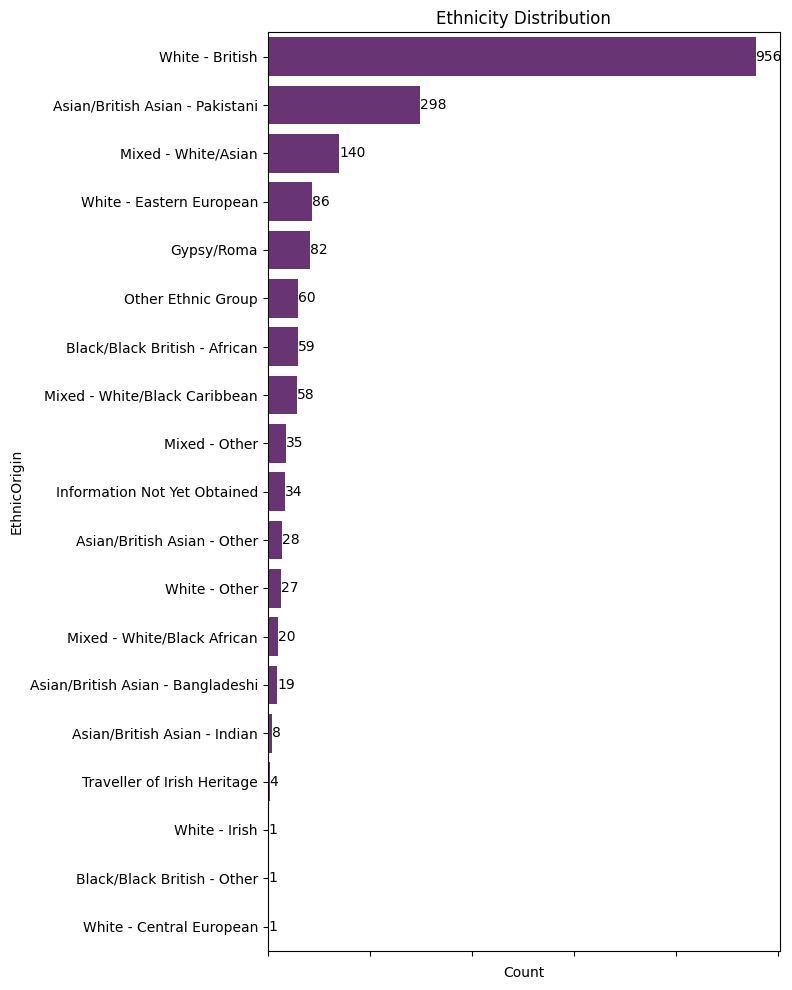

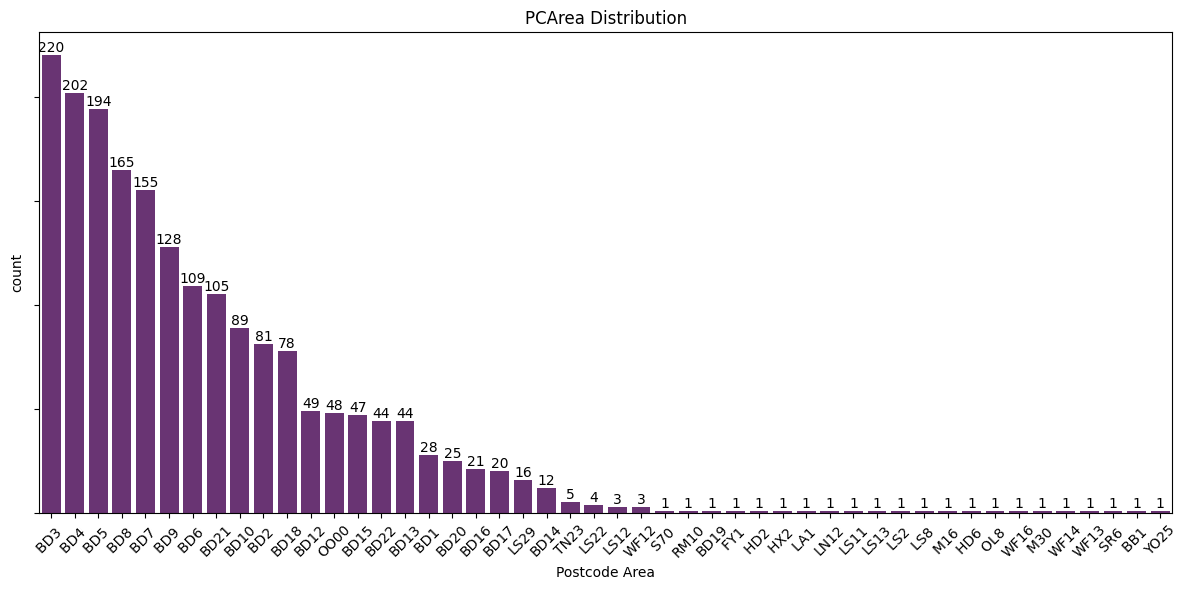

In [65]:
# Plot distibutions of Categorical Data
plot_distributions(lac)

**Observation:**
* White-British and Asian/British Asian-Pakistani dominates the children in care (65% combined)
* There are postcodes in the dataset that are outside of Bradford
* There is a placeholder postcode with 48 entries "OO00"

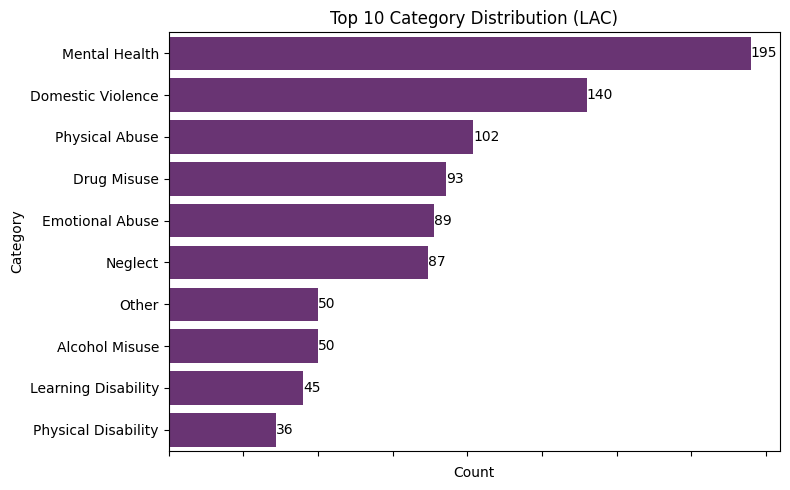

In [66]:
# Plot Top 10 Categories Distribution
plot_top_n_category_distribution(lac, category_col="Category", n=10, intervention_name="LAC")

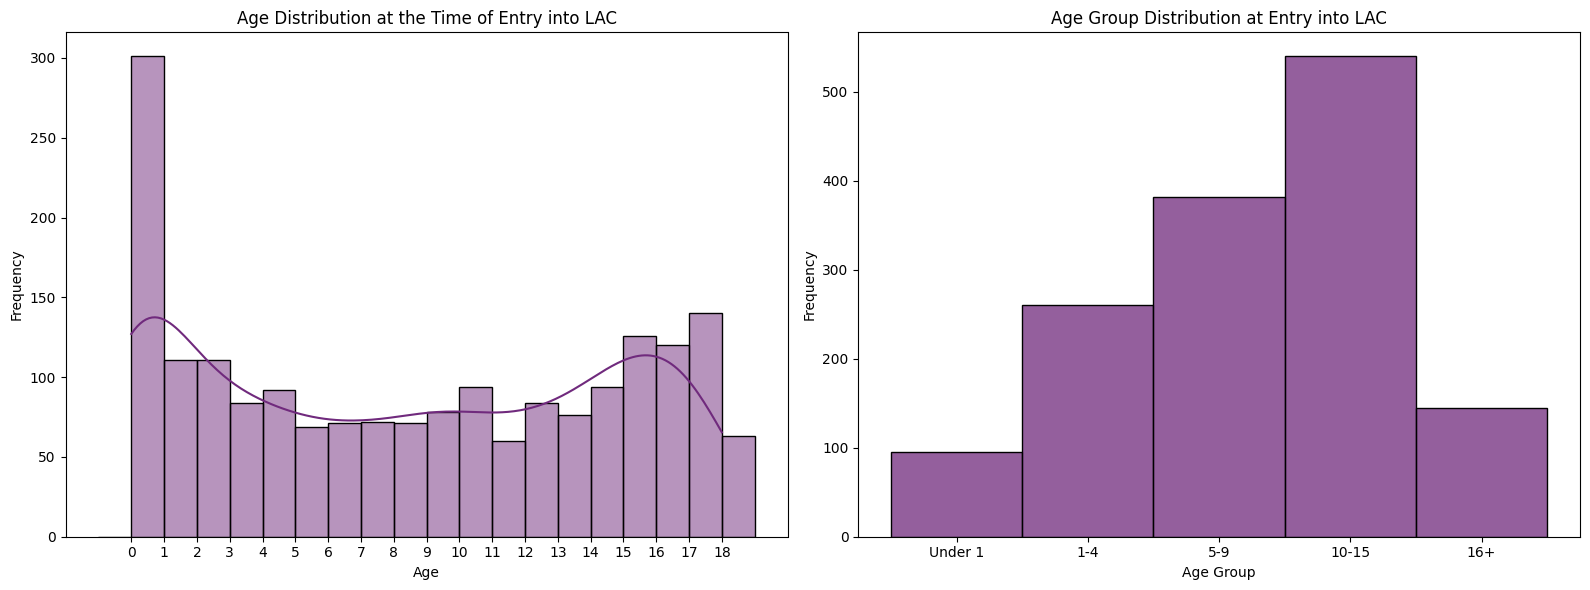

In [67]:
# Plot age distribution in lac
plot_age_distribution(lac, 'LAC', 'StartDate', 'DateOfBirth')

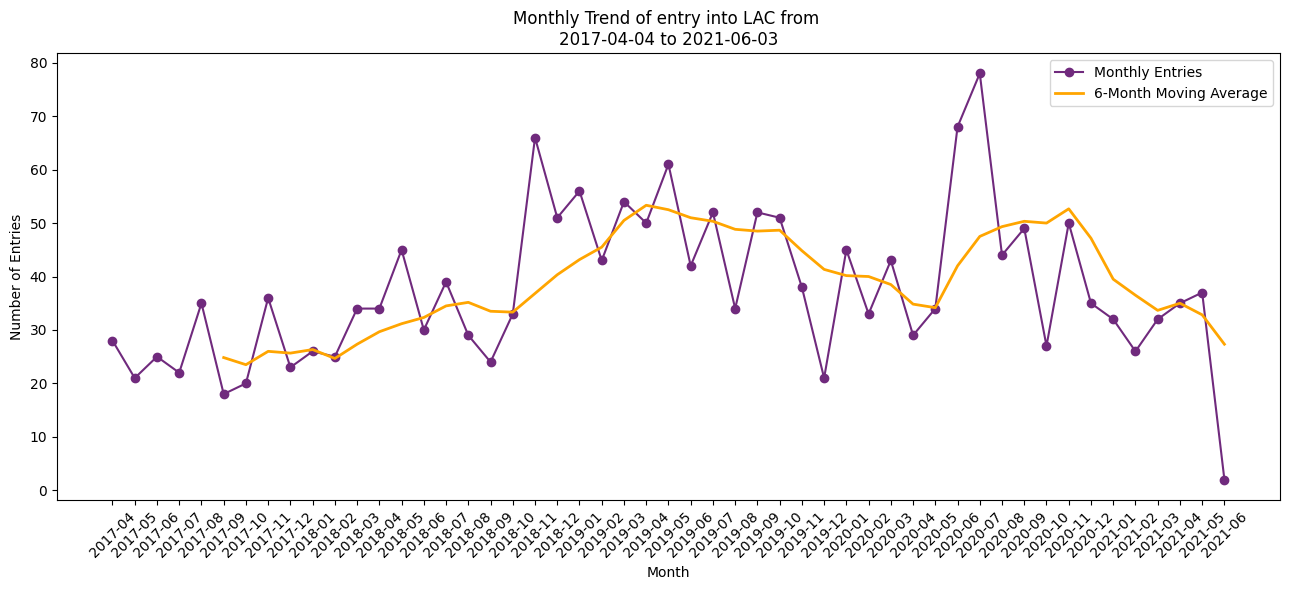

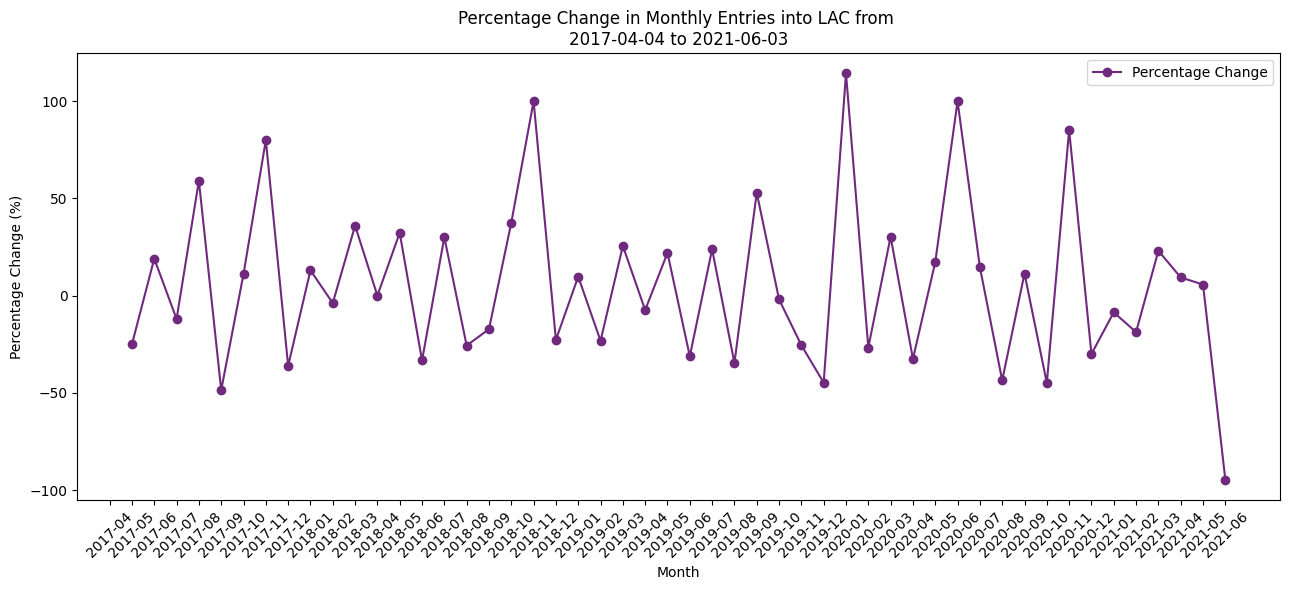

In [68]:
# Plot monthly moving average of entries and percentage change
plot_monthly_trends(lac, 'LAC', 'StartDate', window=6)

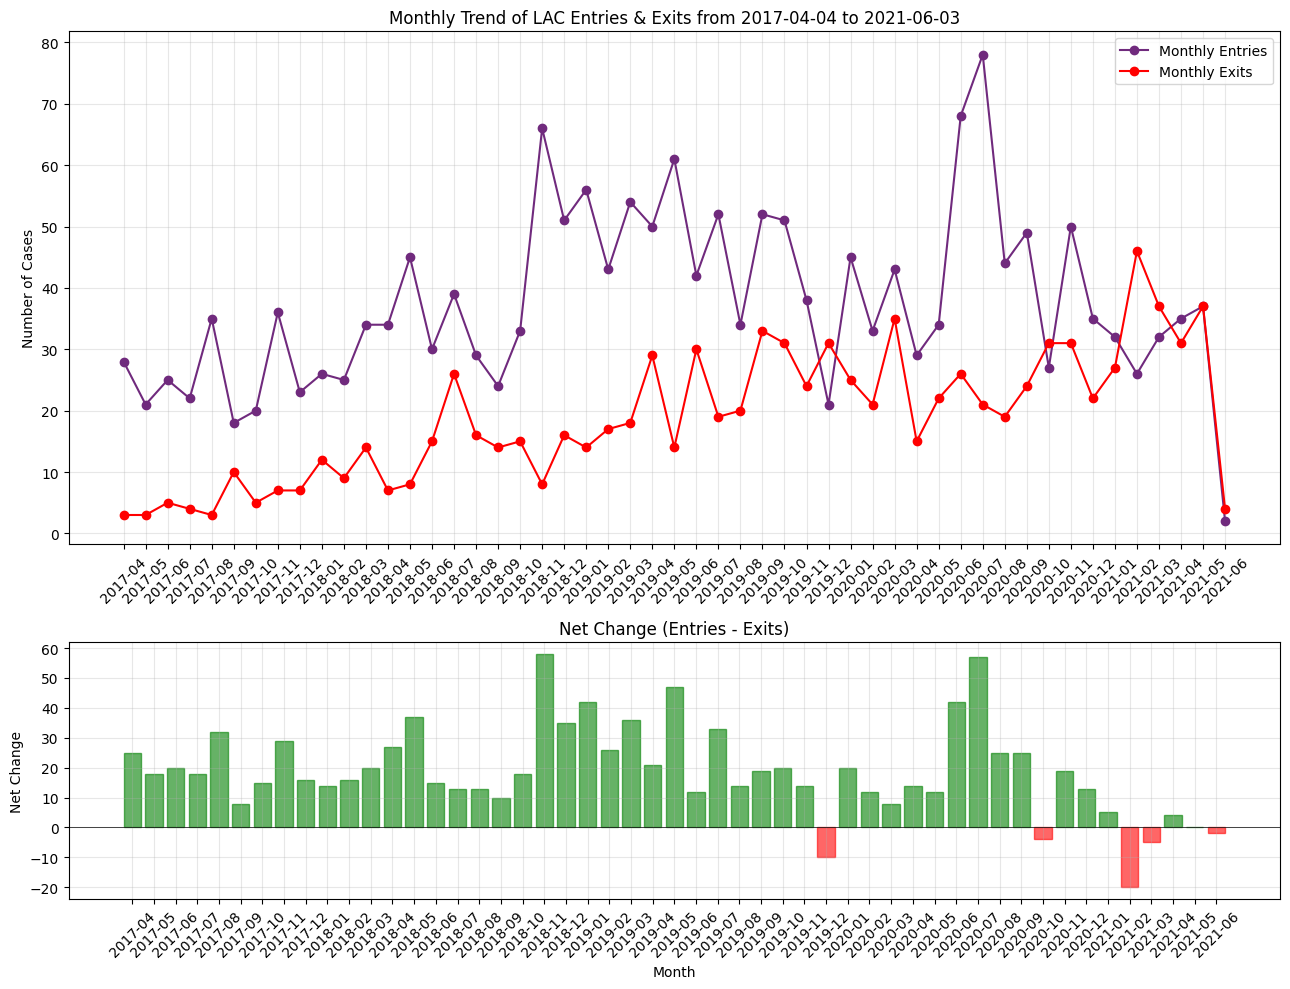


Summary of Net Changes for LAC:
Average monthly net change: 18.7
Maximum increase: 58
Maximum decrease: -20
Months with net increase: 45
Months with net decrease: 5


In [69]:
# Monthly Entries and Exits Trends
plot_monthly_entries_exits(lac, 'StartDate', 'EndDate', 'LAC')

**Observation:**
* Children are entering LAC more than they are leaving. For every month where there are more exits than entries, there are 9 months where there are more entries than exits.

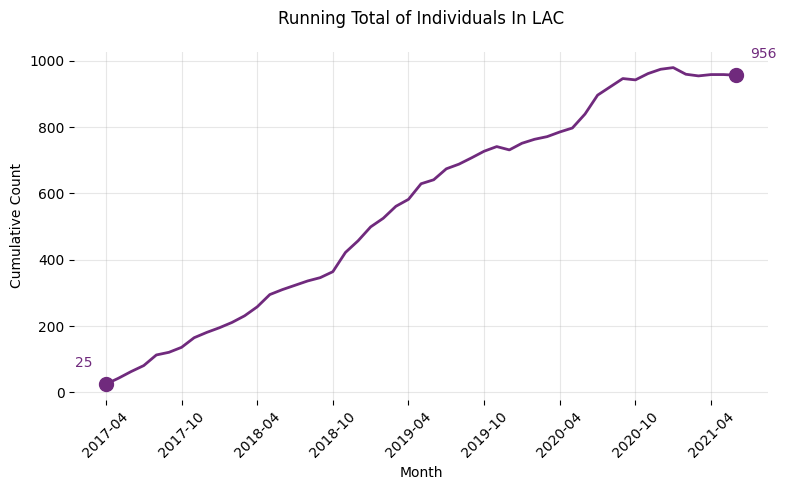

In [70]:
# Plot the cumulative sum of children in care from start of the dataset.
# It assumes that there are no children in care before the start date of the dataset
plot_running_total_in_intervention(lac, 'StartDate', 'EndDate', 'LAC')

The above plot assumes that there are no children in care before the start date of the dataset.<br>
The plot shows steady increase in the amount of children in care

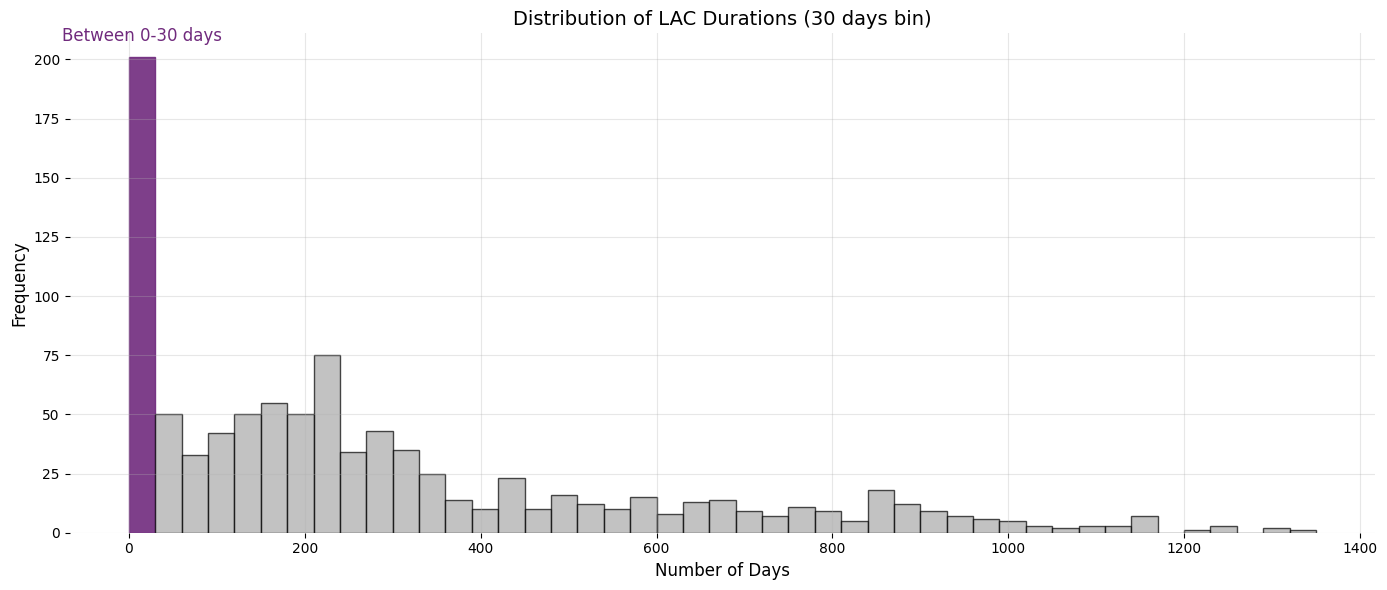

In [71]:
# Distribution of number of days in LAC
plot_duration_in_intervention(lac, 'StartDate', 'EndDate', 'LAC')

In [72]:
lac["num_of_days_in_intervention"].describe()

count         961.0
mean     290.833507
std      295.359843
min             1.0
25%            48.0
50%           209.0
75%           426.0
max          1349.0
Name: num_of_days_in_intervention, dtype: Float64

The above plot shows that most children stay in LAC for 30 days.

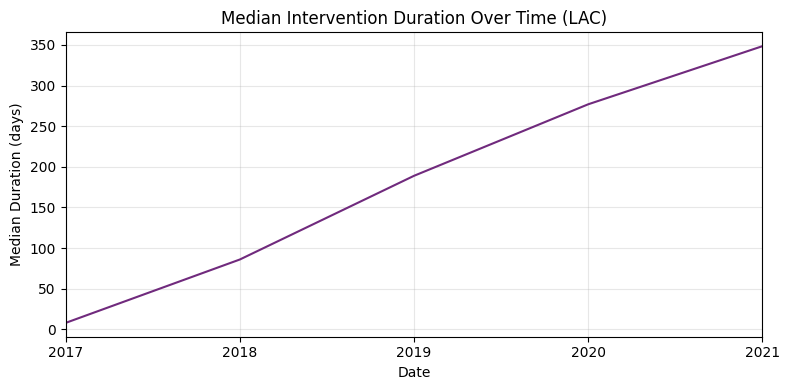

In [73]:
# Median Intervention Duration Over time
plot_median_intervention_duration_over_time(lac, end_date_col="EndDate", duration_col="num_of_days_in_intervention", intervention_name="LAC")

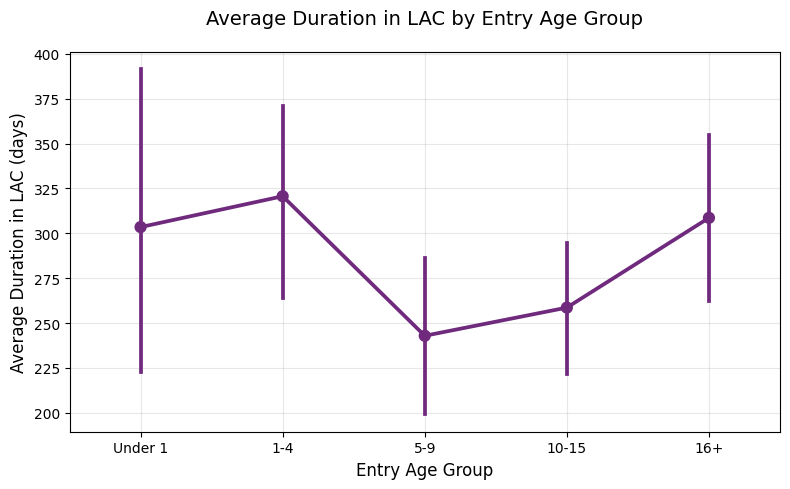

In [74]:
plot_average_duration_by_age(lac, 'LAC')

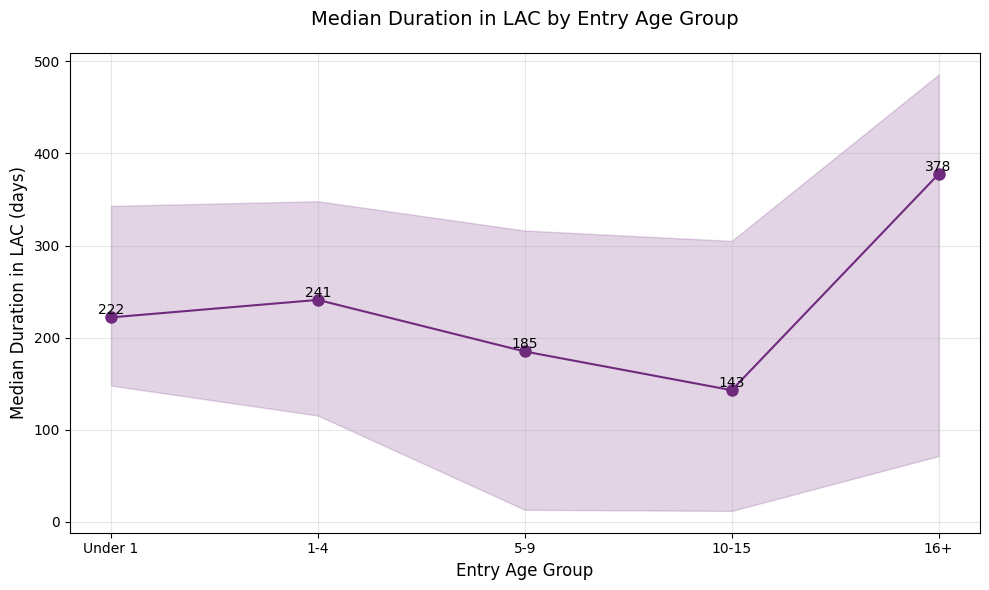

In [75]:
plot_median_duration_by_age(lac, 'LAC')

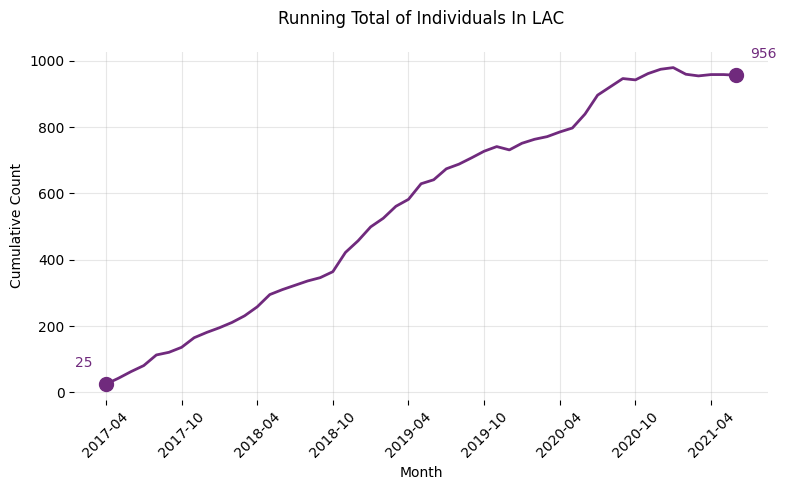

In [76]:
plot_running_total_in_intervention(lac, 'StartDate', 'EndDate', 'LAC', color=color)

In [77]:
# Proportion of children still in the system (No end dates)
num_of_children_with_no_enddate = lac.EndDate.isnull().sum()
total_children_in_lac = len(lac)
proportion_with_no_enddate = round((num_of_children_with_no_enddate/total_children_in_lac)*100, 2)
print(f"Proportion of children still in the LAC system: {proportion_with_no_enddate}%")

Proportion of children still in the LAC system: 49.87%


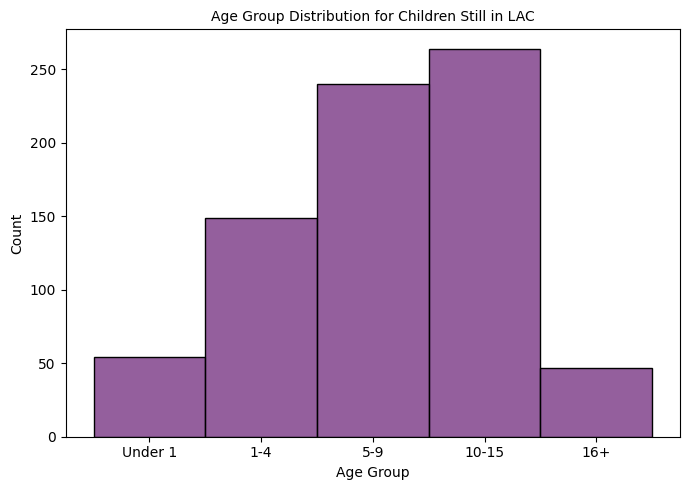

In [78]:
# Age Group distribution of Children still in care
plot_age_groups_for_children_still_in_care(lac, end_date_col="EndDate", age_group_col="entry_agegroup", intervention_name="LAC")

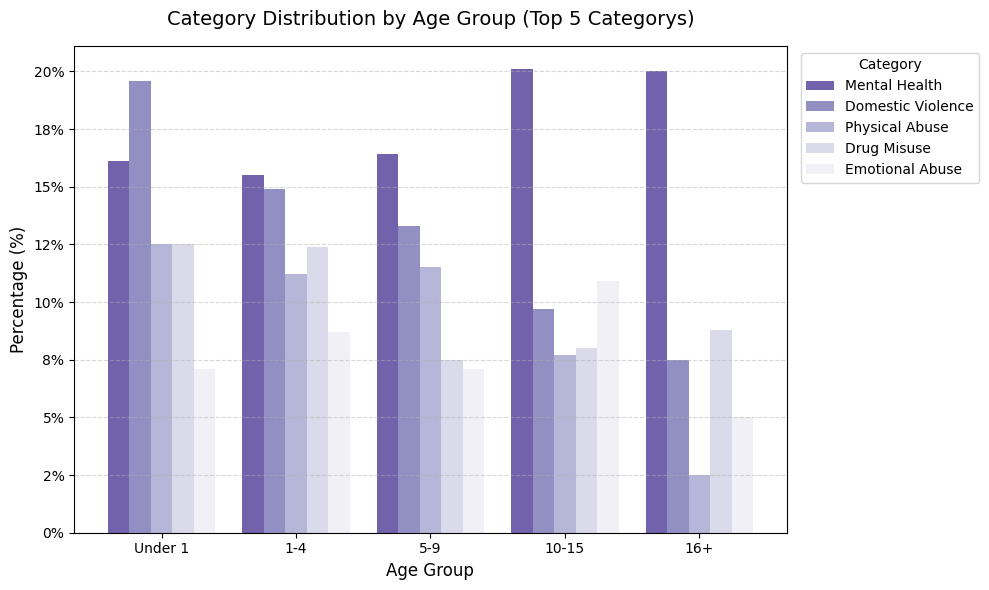

In [90]:
# Age_group by Top 5 Category
plot_agegroup_distribution_top_categories(
    lac,
    'LAC',
    category_col='Category',
    agegroup_col='entry_agegroup',
    n=5
)

# Trial and Error Plots ⬇️

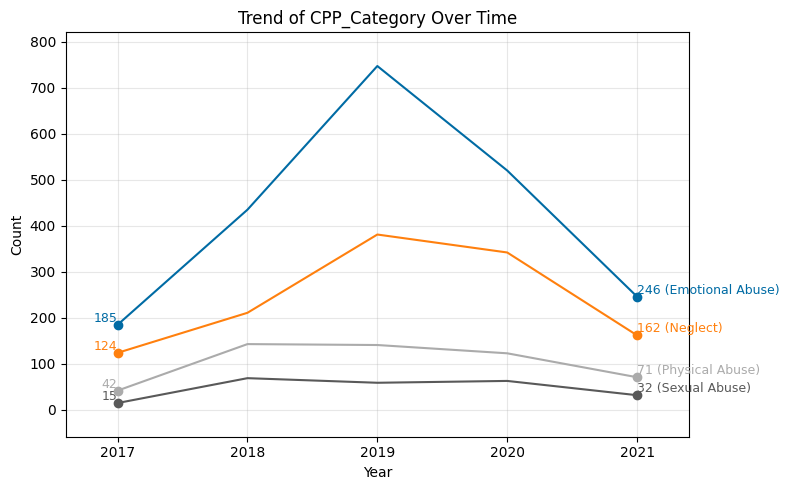

In [80]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert StartDate to datetime and extract year


# Group by Year and CPP_Category to get counts
cpp_counts = cpp.groupby(['Year', 'CPP_Category']).size().unstack(fill_value=0)

# Start and end years
start_year = cpp_counts.index.min()
end_year = cpp_counts.index.max()

# Plotting
plt.figure(figsize=(8, 5))

# Plot each CPP_Category
for category in cpp_counts.columns:
    # Plot the line without markers
    line = plt.plot(cpp_counts.index, cpp_counts[category], label='_nolegend_')
    color = line[0].get_color()  # Get the color of the line

    # Add markers only at start and end points
    plt.scatter([start_year, end_year], 
                [cpp_counts.loc[start_year, category], 
                 cpp_counts.loc[end_year, category]], 
                color=color, zorder=5)

    # Annotate starting value
    plt.text(start_year, cpp_counts.loc[start_year, category], 
             f'{cpp_counts.loc[start_year, category]}', 
             fontsize=9, ha='right', va='bottom', color=color)

    # Annotate ending value and category label
    plt.text(end_year, cpp_counts.loc[end_year, category], 
             f'{cpp_counts.loc[end_year, category]} ({category})', 
             fontsize=9, ha='left', va='bottom', color=color)

# Adjust plot margins to prevent labels from being cut off
plt.margins(x=0.1, y=0.1)

# Customize plot
plt.title('Trend of CPP_Category Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True, alpha=.3)
# Show plot
plt.tight_layout()
plt.show()